In [2]:
# Import necessary Python packages and modules
import site
print(site.getsitepackages())  # Show Python package installation locations
import sys
print(sys.path)  # Show Python module search path
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc  # Single-cell analysis package
import seaborn as sns  # Statistical data visualization
from tqdm.notebook import tqdm  # Progress bars for Jupyter
import scipy.sparse as sp  # Sparse matrix operations
import scvi  # Single-cell variational inference tools
import anndata as ad  # AnnData object for single-cell data
import anndata
from scvi.model import SCVI  # SCVI model for integration
from sklearn.preprocessing import scale  # Data scaling
from sklearn.utils import resample  # Resampling utilities

# Set default figure parameters for scanpy
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()  # Set seaborn theme
save_dir = tempfile.TemporaryDirectory()  # Create temporary directory for saving files

# Configure Jupyter notebook display settings
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Set number of threads for scvi computations
scvi.settings.num_threads = 25

# Configure pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)  # Show up to 100 rows

['/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']
['/home1/ds286q/Organoid D15-21', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home1/ds286q/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages']


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidget

In [3]:
from platform import python_version
print(python_version())

print(scvi.__version__)
print(sc.__version__)

3.10.12
1.0.2
1.9.3


# Import object from Seurat

In [87]:
# Load single-cell datasets in h5ad format (AnnData objects)

#Synovial organoid macrophage batch 1
SOM = sc.read_h5ad("/datastore/Dom/Saved/Mar25_Organoid/Mar25.SOM.h5ad")
#Synovial Tissue macrophage
STM = sc.read_h5ad("/datastore/Dom/Saved/Mar25_Organoid/Mar25.STM.h5ad")
#Synovial organoid Macrophage batch 2
C1 = sc.read_h5ad("/datastore/Dom/Saved/Mar25_Organoid/Mar25.C1.macro.h5ad")
#Synovial organoid Macrophage SF
Eva = sc.read_h5ad("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Eva.M.macro.h5ad")

In [88]:
# Fix column names in raw data attributes for each dataset
# Rename '_index' column to 'features' in raw data variance for compatibility

SOM.__dict__['_raw'].__dict__['_var']=SOM.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
STM.__dict__['_raw'].__dict__['_var']=STM.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
C1.__dict__['_raw'].__dict__['_var']=C1.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
Eva.__dict__['_raw'].__dict__['_var']=Eva.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [89]:
# Load metadata for each dataset
SOM_meta = pd.read_csv("/datastore/Dom/Saved/Mar25_Organoid/Mar25.SOM.meta.csv", index_col=0)
STM_meta = pd.read_csv("/datastore/Dom/Saved/Mar25_Organoid/Mar25.STM.meta.csv", index_col=0)
C1_meta = pd.read_csv("/datastore/Dom/Saved/Mar25_Organoid/Mar25.C1.meta.csv", index_col=0)
Eva_meta = pd.read_csv("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Eva.meta.csv", index_col=0)

In [90]:
STM.obs.head()

orig.ident   nCount_RNA  nFeature_RNA  STACASclusters  \
AAACCTGTCCGTAGTA-1_1_1           0  3827.602855          1224              11   
AAACCTGTCTCTAGGA-1_1_1           0  1516.172532           716               6   
AAAGATGGTTCGCTAA-1_1_1           0  3338.377717          1171               9   
AAAGATGTCGTGACAT-1_1_1           0  5134.377827          1411              10   
AACACGTAGAGCTGGT-1_1_1           0  8352.686387          1796              15   

                       STACASExperiment STACASsample  
AAACCTGTCCGTAGTA-1_1_1         Immunity       HC0547  
AAACCTGTCTCTAGGA-1_1_1         Immunity       HC0547  
AAAGATGGTTCGCTAA-1_1_1         Immunity       HC0547  
AAAGATGTCGTGACAT-1_1_1         Immunity       HC0547  
AACACGTAGAGCTGGT-1_1_1         Immunity       HC0547

In [91]:
C1.obs.head()
C1.obs.index
type(C1.obs.index[1])

str

In [92]:
type(C1_meta.index[1])

numpy.int64

In [93]:
# Ensure metadata indices are strings for consistency
C1_meta.index = C1_meta.index.map(str)
type(C1_meta.index[1])

str

In [94]:
Eva_meta.index

Int64Index([    1022,    19855,    88589,   102953,   139649,   145527,
              145927,   148709,   164543,   178553,
            ...
            56466141, 56508532, 56535634, 56549085, 56558000, 56570281,
            56575791, 56581519, 56596774, 56597423],
           dtype='int64', length=2145)

In [95]:
Eva_meta.index = Eva_meta.index.map(str)

In [96]:
print(SOM_meta.dtypes)

orig.ident          object
STACASclusters      object
STACASExperiment    object
STACASsample        object
dtype: object


In [97]:
# Convert metadata columns to categorical data type for efficiency and memory optimization
SOM_meta["STACASExperiment"] = SOM_meta["STACASExperiment"].astype(str).astype("category")
SOM_meta["STACASsample"] = SOM_meta["STACASsample"].astype(str).astype("category")
SOM_meta["STACASclusters"] = SOM_meta["STACASclusters"].astype(str).astype("category")
SOM_meta["orig.ident"] = SOM_meta["orig.ident"].astype(str).astype("category")

STM_meta["STACASExperiment"] = STM_meta["STACASExperiment"].astype(str).astype("category")
STM_meta["STACASsample"] = STM_meta["STACASsample"].astype(str).astype("category")
STM_meta["STACASclusters"] = STM_meta["STACASclusters"].astype(str).astype("category")
STM_meta["orig.ident"] = STM_meta["orig.ident"].astype(str).astype("category")

C1_meta["STACASExperiment"] = C1_meta["STACASExperiment"].astype(str).astype("category")
C1_meta["STACASsample"] = C1_meta["STACASsample"].astype(str).astype("category")
C1_meta["STACASclusters"] = C1_meta["STACASclusters"].astype(str).astype("category")
C1_meta["orig.ident"] = C1_meta["orig.ident"].astype(str).astype("category")

Eva_meta["STACASExperiment"] = Eva_meta["STACASExperiment"].astype(str).astype("category")
Eva_meta["STACASsample"] = Eva_meta["STACASsample"].astype(str).astype("category")
Eva_meta["STACASclusters"] = Eva_meta["STACASclusters"].astype(str).astype("category")
Eva_meta["orig.ident"] = Eva_meta["orig.ident"].astype(str).astype("category")

In [103]:
# Assign processed metadata back to AnnData objects
STM.obs = STM_meta
SOM.obs = SOM_meta
C1.obs = C1_meta
Eva.obs = Eva_meta

In [104]:
STM.obs

orig.ident                STACASclusters  \
AAACCTGTCCGTAGTA-1_1_1     HC0547  FOLR2highSELENOP+ Macrophage   
AAACCTGTCTCTAGGA-1_1_1     HC0547   C1QAhighHMOX1+ Intermediate   
AAAGATGGTTCGCTAA-1_1_1     HC0547             TREM2+ Macrophage   
AAAGATGTCGTGACAT-1_1_1     HC0547    FOLR2highLYVE1+ Macrophage   
AACACGTAGAGCTGGT-1_1_1     HC0547                     CD1c+ cDC   
...                           ...                           ...   
14041360_3                     O3                     CD1c+ cDC   
14041752_3                     O3         CD14+FCGR3A+ Monocyte   
14042505_3                     O3     CD14highS100A12+ Monocyte   
14043339_3                     O3     CD14highS100A12+ Monocyte   
14043703_3                     O3         SDS+NR4A3+CXCR4+ iDC3   

                       STACASExperiment STACASsample  
AAACCTGTCCGTAGTA-1_1_1         Immunity       HC0547  
AAACCTGTCTCTAGGA-1_1_1         Immunity       HC0547  
AAAGATGGTTCGCTAA-1_1_1         Immunity       HC0547  
AAAGATGTCGTGACAT-1_1_1         Immunity       HC0547  
AACACGTAGAGCTGGT-1_1_1         Immunity       HC0547  
...                                 ...          ...  
14041360_3                     Immunity           O3  
14041752_3                     Immunity           O3  
14042505_3                     Immunity           O3  
14043339_3                     Immunity           O3  
14043703_3                     Immunity           O3  

[70471 rows x 4 columns]

In [105]:
# Downsample the STM dataset to balance cluster sizes
n_cells_max = 2000

# Perform stratified downsampling: sample up to n_cells_max from each cluster
downsampled_indices = (
    STM.obs.groupby("STACASclusters", group_keys=False)
    .apply(lambda x: x.sample(min(len(x), n_cells_max), random_state=42))
    .index.to_list()  
)

# Create subset of STM data using downsampled indices
STM_subset = STM[downsampled_indices, :].copy()
print(STM_subset.obs["STACASclusters"].value_counts())

C1QAhighHMOX1+ Intermediate     2000
FOLR2highLYVE1+ Macrophage      2000
SPP1+TREM2low Macrophage        2000
SPP1+ Macrophage                2000
SDS+NR4A3+CXCR4+ iDC3           2000
ISG15+ Intermediate             2000
FOLR2highSELENOP+ Macrophage    2000
FOLR2highEGR1+ Macrophage       2000
FOLR2highCLEC10A+ Macrophage    2000
FCGR3A+ Monocyte                2000
CD1c+ cDC                       2000
CD14highS100A12+ Monocyte       2000
CD14+FCGR3A+ Monocyte           2000
TREM2+ Macrophage               2000
TNF+ICAM1+ Macrophage           1003
CXCL10+STAT1+ Macrophage         514
CCR7+/CLEC9A+ DC1                335
Name: STACASclusters, dtype: int64


In [106]:
STM_subset.obs["STACASclusters"]

TACGCTCTCTTAAGGC-1_1_24     C1QAhighHMOX1+ Intermediate
TTGCTGCCAATCGAAA-1_5_35     C1QAhighHMOX1+ Intermediate
TGTTACTCATTCAGCA-1_3_26     C1QAhighHMOX1+ Intermediate
CGGACGTGTACAGTGG-1_12_12    C1QAhighHMOX1+ Intermediate
GTCCACTGTCTCGGAC-1_2_25     C1QAhighHMOX1+ Intermediate
                                       ...             
GCTCCTAAGGCATTGG-1_14_14              TREM2+ Macrophage
TACCGGGGTACACGCC-1_1_31               TREM2+ Macrophage
GCCTGTTGTAGCGTCC-1_1_24               TREM2+ Macrophage
CGGACACCACATCCAA-1_14_14              TREM2+ Macrophage
TCGAACAGTGGCGTAA-1_1_24               TREM2+ Macrophage
Name: STACASclusters, Length: 29852, dtype: category
Categories (17, object): ['C1QAhighHMOX1+ Intermediate', 'CCR7+/CLEC9A+ DC1', 'CD14+FCGR3A+ Monocyte', 'CD14highS100A12+ Monocyte', ..., 'SPP1+ Macrophage', 'SPP1+TREM2low Macrophage', 'TNF+ICAM1+ Macrophage', 'TREM2+ Macrophage']

In [107]:
# Add source information to each dataset
STM_subset.obs["source"] = "Human"
STM_subset.obs["source"] = STM_subset.obs["source"].astype(str).astype("category")
SOM.obs["source"] = "Organoid"
SOM.obs["source"] = SOM.obs["source"].astype(str).astype("category")
C1.obs["source"] = "Organoid"
C1.obs["source"] = C1.obs["source"].astype(str).astype("category")
Eva.obs["source"] = "Organoid"
Eva.obs["source"] = Eva.obs["source"].astype(str).astype("category")

In [108]:
# Concatenate all datasets into a single AnnData object
original_adata = anndata.concat([STM_subset, SOM, C1, Eva], index_unique="M")
original_adata

AnnData object with n_obs × n_vars = 43410 × 15115
    obs: 'orig.ident', 'STACASclusters', 'STACASExperiment', 'STACASsample', 'source'

In [109]:
original_adata.X

<43410x15115 sparse matrix of type '<class 'numpy.float64'>'
	with 81371695 stored elements in Compressed Sparse Row format>

In [110]:
# Find genes common to all datasets for integration
common_genes = STM_subset.var_names.intersection(SOM.var_names)
print(f"Number of common genes: {len(common_genes)}")
common_genes = common_genes.intersection(C1.var_names)
print(f"Number of common genes: {len(common_genes)}")
common_genes = common_genes.intersection(Eva.var_names)
print(f"Number of common genes: {len(common_genes)}")

Number of common genes: 16477
Number of common genes: 15885
Number of common genes: 15493
Number of common genes: 15115


In [111]:
# Filter each dataset to only include common genes for compatibility
STM_subset = STM_subset[:, common_genes]
SOM = SOM[:, common_genes]
C1 = C1[:, common_genes]
Eva = Eva[:, common_genes]


In [112]:
# Note: concatenate method seems deprecated, using anndata.concat instead

# Merge filtered datasets
merged_adata = anndata.concat([STM_subset, SOM, C1, Eva], index_unique="M")

In [113]:
merged_adata

AnnData object with n_obs × n_vars = 43410 × 15115
    obs: 'orig.ident', 'STACASclusters', 'STACASExperiment', 'STACASsample', 'source'

In [114]:
merged_adata.obs["STACASExperiment"].value_counts()

Immunity         29852
Organoid2_D15     5645
Organoid2_D21     3522
Organoid1         2246
Organoid_Unst     1160
Organoid_SF        985
Name: STACASExperiment, dtype: int64

In [115]:
# Check for and handle duplicate observations
merged_adata.obs.duplicated().any()

True

In [116]:
merged_adata.obs.duplicated()

TACGCTCTCTTAAGGC-1_1_24M0     False
TTGCTGCCAATCGAAA-1_5_35M0     False
TGTTACTCATTCAGCA-1_3_26M0     False
CGGACGTGTACAGTGG-1_12_12M0    False
GTCCACTGTCTCGGAC-1_2_25M0     False
                              ...  
56570281M4                     True
56575791M4                     True
56581519M4                     True
56596774M4                     True
56597423M4                     True
Length: 43410, dtype: bool

In [117]:
merged_adata.obs_names_make_unique()

In [118]:
merged_adata.obs.duplicated().any()

True

In [119]:
# Fill missing cluster labels with "unknown"
merged_adata.obs["STACASclusters"].fillna("unknown", inplace=True)

In [120]:
merged_adata.obs.head()

orig.ident               STACASclusters  \
TACGCTCTCTTAAGGC-1_1_24M0        SA272_SYN  C1QAhighHMOX1+ Intermediate   
TTGCTGCCAATCGAAA-1_5_35M0               A5  C1QAhighHMOX1+ Intermediate   
TGTTACTCATTCAGCA-1_3_26M0        SA276_SYN  C1QAhighHMOX1+ Intermediate   
CGGACGTGTACAGTGG-1_12_12M0  ResistantSA151  C1QAhighHMOX1+ Intermediate   
GTCCACTGTCTCGGAC-1_2_25M0        SA271_SYN  C1QAhighHMOX1+ Intermediate   

                           STACASExperiment    STACASsample source  
TACGCTCTCTTAAGGC-1_1_24M0          Immunity       SA272_SYN  Human  
TTGCTGCCAATCGAAA-1_5_35M0          Immunity              A5  Human  
TGTTACTCATTCAGCA-1_3_26M0          Immunity       SA276_SYN  Human  
CGGACGTGTACAGTGG-1_12_12M0         Immunity  ResistantSA151  Human  
GTCCACTGTCTCGGAC-1_2_25M0          Immunity       SA271_SYN  Human

In [121]:
merged_adata.obs.tail()

orig.ident STACASclusters STACASExperiment STACASsample    source
56570281M4      M_SMK            nan      Organoid_SF           SF  Organoid
56575791M4      M_SMK            nan    Organoid_Unst         Unst  Organoid
56581519M4      M_SMK            nan    Organoid_Unst         Unst  Organoid
56596774M4      M_SMK            nan    Organoid_Unst         Unst  Organoid
56597423M4      M_SMK            nan    Organoid_Unst         Unst  Organoid

In [122]:
# Print information about the merged dataset
print("Merged AnnData:", merged_adata)
print(merged_adata.obs.head()) 
print(merged_adata.obs.isnull().sum())

Merged AnnData: AnnData object with n_obs × n_vars = 43410 × 15115
    obs: 'orig.ident', 'STACASclusters', 'STACASExperiment', 'STACASsample', 'source'
                                orig.ident               STACASclusters  \
TACGCTCTCTTAAGGC-1_1_24M0        SA272_SYN  C1QAhighHMOX1+ Intermediate   
TTGCTGCCAATCGAAA-1_5_35M0               A5  C1QAhighHMOX1+ Intermediate   
TGTTACTCATTCAGCA-1_3_26M0        SA276_SYN  C1QAhighHMOX1+ Intermediate   
CGGACGTGTACAGTGG-1_12_12M0  ResistantSA151  C1QAhighHMOX1+ Intermediate   
GTCCACTGTCTCGGAC-1_2_25M0        SA271_SYN  C1QAhighHMOX1+ Intermediate   

                           STACASExperiment    STACASsample source  
TACGCTCTCTTAAGGC-1_1_24M0          Immunity       SA272_SYN  Human  
TTGCTGCCAATCGAAA-1_5_35M0          Immunity              A5  Human  
TGTTACTCATTCAGCA-1_3_26M0          Immunity       SA276_SYN  Human  
CGGACGTGTACAGTGG-1_12_12M0         Immunity  ResistantSA151  Human  
GTCCACTGTCTCGGAC-1_2_25M0          Immunity       S

In [123]:
merged_adata.obs["STACASclusters"].isna()

TACGCTCTCTTAAGGC-1_1_24M0     False
TTGCTGCCAATCGAAA-1_5_35M0     False
TGTTACTCATTCAGCA-1_3_26M0     False
CGGACGTGTACAGTGG-1_12_12M0    False
GTCCACTGTCTCGGAC-1_2_25M0     False
                              ...  
56570281M4                    False
56575791M4                    False
56581519M4                    False
56596774M4                    False
56597423M4                    False
Name: STACASclusters, Length: 43410, dtype: bool

In [124]:
print(merged_adata.obs["STACASclusters"][-1])
type(merged_adata.obs["STACASclusters"][-1])

nan


str

# Integration

## integration preprocessing

In [125]:
# Calculate median counts for normalization
median_counts = np.median(np.array(merged_adata.X.sum(axis=1)).flatten())
print(f"Median total counts per cell: {median_counts}")

# Normalize total counts to median
sc.pp.normalize_total(merged_adata, target_sum=median_counts)
sc.pp.log1p(merged_adata)
merged_adata.layers["counts"] = merged_adata.X.copy()

Median total counts per cell: 5629.0


In [126]:
merged_adata.layers["counts"] = merged_adata.X.copy()
sc.pp.normalize_total(merged_adata)
sc.pp.log1p(merged_adata)

In [127]:
print(f"Number of genes before HVG selection: {merged_adata.n_vars}")

# Select highly variable genes for integration
sc.pp.highly_variable_genes(
    merged_adata,
    flavor="seurat_v3",
    n_top_genes=2500,
    layer="counts",
    batch_key="source",
    subset=True,
)
print(f"Number of genes after HVG selection: {merged_adata.n_vars}")

Number of genes before HVG selection: 15115


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Number of genes after HVG selection: 2500


In [128]:
# Define keys for storing integration results
SCVI_LATENT_KEY = "X_scVI"
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "predictions_scanvi"
SCVI_CLUSTERS_KEY = "leiden_scVI"
SCANVI_PREDICTIONS_SCORE = "score_scanvi"

In [129]:
merged_adata.obs.columns

Index(['orig.ident', 'STACASclusters', 'STACASExperiment', 'STACASsample',
       'source'],
      dtype='object')

## integration

In [130]:
# Set up SCVI model with metadata
scvi.model.SCVI.setup_anndata(merged_adata, layer="counts",labels_key="STACASclusters", batch_key="STACASsample", 
                              categorical_covariate_keys=["source", "STACASExperiment"])

# Initialize SCVI model
scvi_ref = scvi.model.SCVI(merged_adata, n_layers=4, n_latent=30, gene_likelihood="nb")

# Train SCVI model
scvi_ref.train(max_epochs=100, early_stopping=True) # added early_stopping=True

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [8:09:06<00:00, 222.29s/it, v_num=1, train_loss_step=425, train_loss_epoch=427]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [8:09:06<00:00, 293.47s/it, v_num=1, train_loss_step=425, train_loss_epoch=427]


In [131]:
# Store SCVI latent representations
SCVI_LATENT_KEY = "X_scVI"
merged_adata.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()

In [132]:
# Initialize SCANVI model from SCVI for semi-supervised integration
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_ref,
    adata=merged_adata,
    labels_key="STACASclusters",
    unlabeled_category="nan",
)

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [133]:
# Train SCANVI model
scanvi_model.train(max_epochs=100, n_samples_per_label=100, check_val_every_n_epoch=10, early_stopping=True)

INFO     Training for 100 epochs.                                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:51:04<00:00, 627.91s/it, v_num=1, train_loss_step=525, train_loss_epoch=529]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:51:04<00:00, 714.65s/it, v_num=1, train_loss_step=525, train_loss_epoch=529]


In [134]:
# Store SCANVI results
merged_adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation()
merged_adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict()
merged_adata.obs[SCANVI_PREDICTIONS_SCORE] = scanvi_model.predict(soft = True).max(axis = 1)

In [135]:
# Perform clustering and dimensionality reduction on integrated data
sc.pp.neighbors(merged_adata, use_rep = SCANVI_LATENT_KEY)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


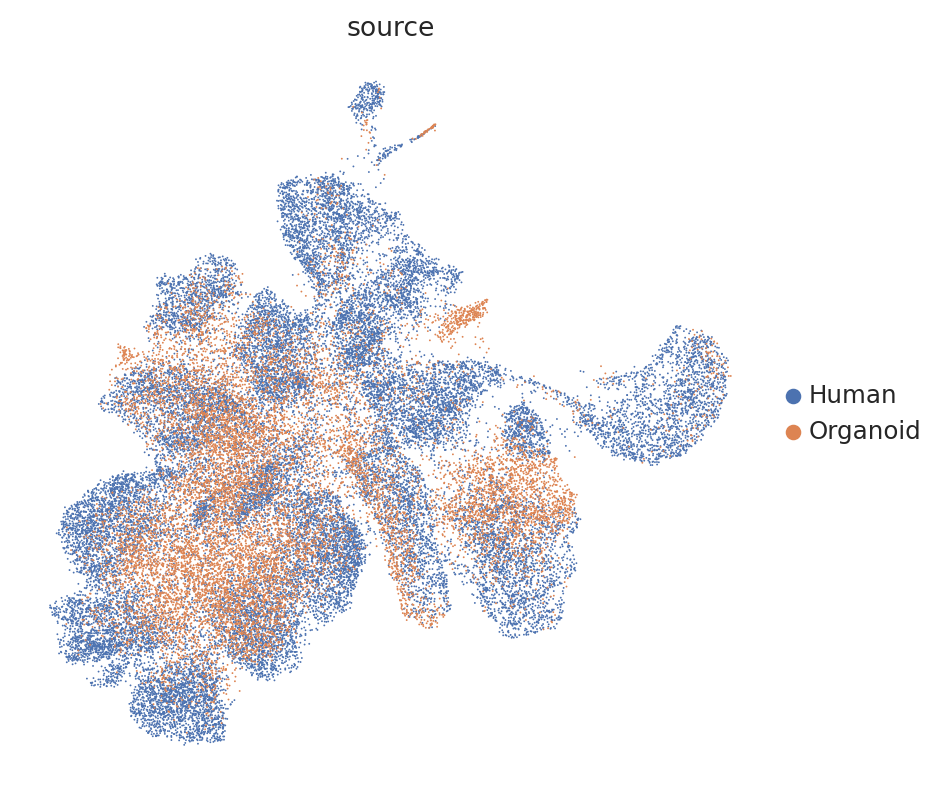

In [136]:
# Leiden clustering on integrated data
sc.tl.leiden(merged_adata, key_added=SCVI_CLUSTERS_KEY, n_iterations = 2)
sc.tl.umap(merged_adata)
sc.pl.umap(merged_adata, color = ["source"], frameon = False, ncols = 1)

In [137]:
tab20_colors = list(plt.get_cmap("tab20").colors)
tab20b_colors = list(plt.get_cmap("tab20b").colors)
extended_palette = tab20_colors + tab20b_colors

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


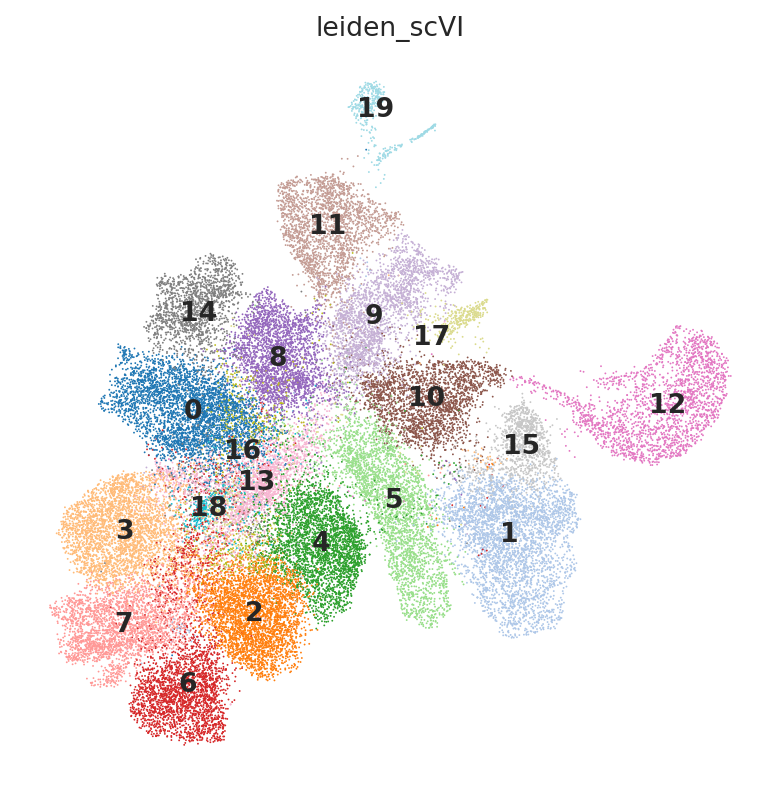

In [138]:
sc.pl.umap(merged_adata, color = [SCVI_CLUSTERS_KEY], frameon = False, ncols = 1, palette=extended_palette, legend_loc="on data")

In [1]:
# Extract UMAP coordinates and cluster assignments for visualization
umap_coords = merged_adata.obsm["X_umap"]
clusters = merged_adata.obs[SCVI_CLUSTERS_KEY].astype(str)

# Create a grid of subplots to visualize each cluster separately
unique_clusters = np.sort(clusters.unique())
n_clusters = len(unique_clusters)
n_cols = 7
n_rows = int(np.ceil(n_clusters / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 1.5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()
for i, cluster in enumerate(unique_clusters):
    ax = axes[i]
    mask = clusters == cluster
    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], color="lightgray", alpha=0.2, s=5)
    ax.scatter(umap_coords[mask, 0], umap_coords[mask, 1], label=f"Cluster {cluster}", s=10)
    ax.set_title(f"Cluster {cluster}", fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

NameError: name 'merged_adata' is not defined

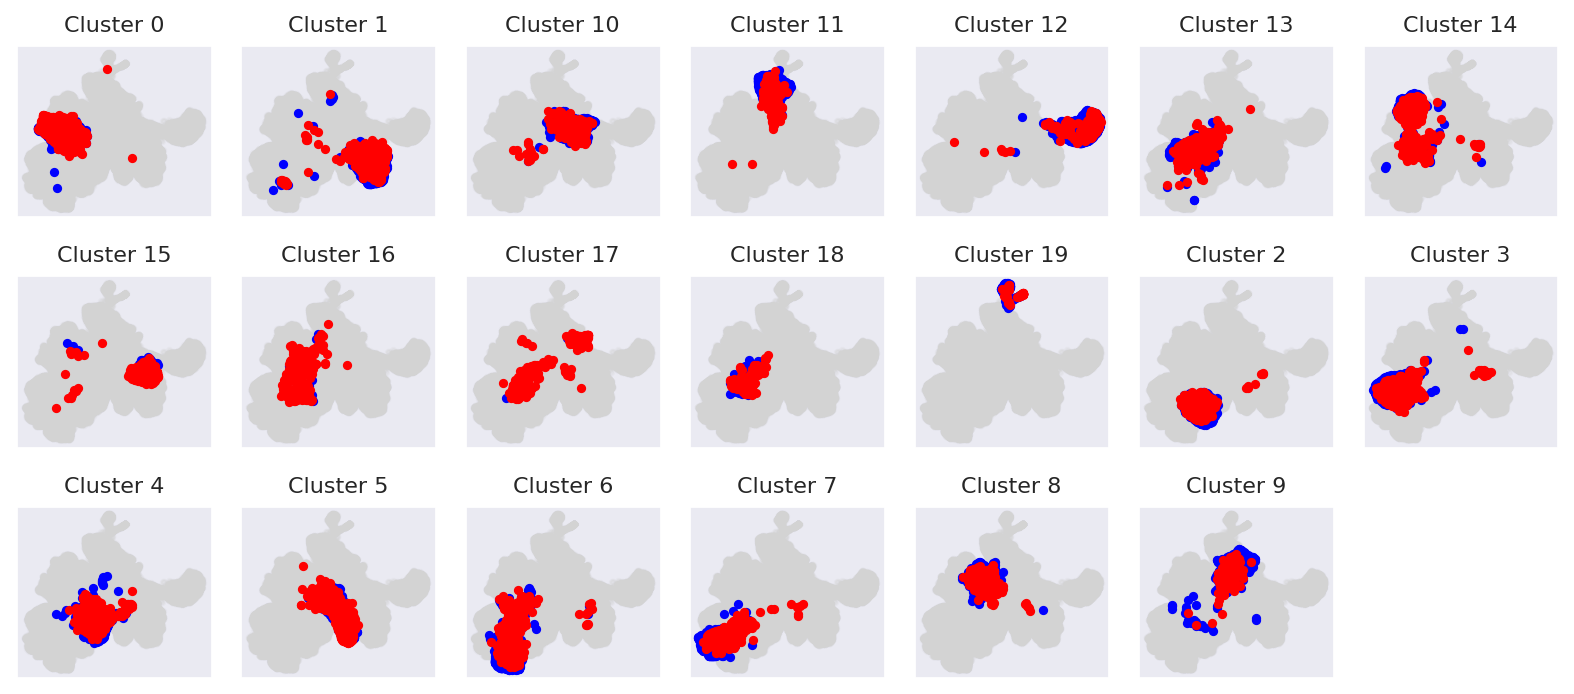

In [140]:
# Extract source information along with cluster assignments
umap_coords = merged_adata.obsm["X_umap"]
clusters = merged_adata.obs[SCVI_CLUSTERS_KEY].astype(str) 
source = merged_adata.obs["source"].astype(str) 
unique_clusters = np.sort(clusters.unique())
n_clusters = len(unique_clusters)
n_cols = 7
n_rows = int(np.ceil(n_clusters / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 1.5 * n_rows), sharex=True, sharey=True)

axes = axes.flatten()
# Define colors for different sources
species_colors = {"Human": "blue", "Organoid": "red"}
for i, cluster in enumerate(unique_clusters):
    ax = axes[i]
    cluster_mask = clusters == cluster
    human_mask = cluster_mask & (source == "Human")
    organoids_mask = cluster_mask & (source == "Organoid")
    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], color="lightgray", alpha=0.2, s=5)
    ax.scatter(umap_coords[human_mask, 0], umap_coords[human_mask, 1], color=species_colors["Human"], s=10, label="Human")
    ax.scatter(umap_coords[organoids_mask, 0], umap_coords[organoids_mask, 1], color=species_colors["Organoid"], s=10, label="Organoid")
    ax.set_title(f"Cluster {cluster}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


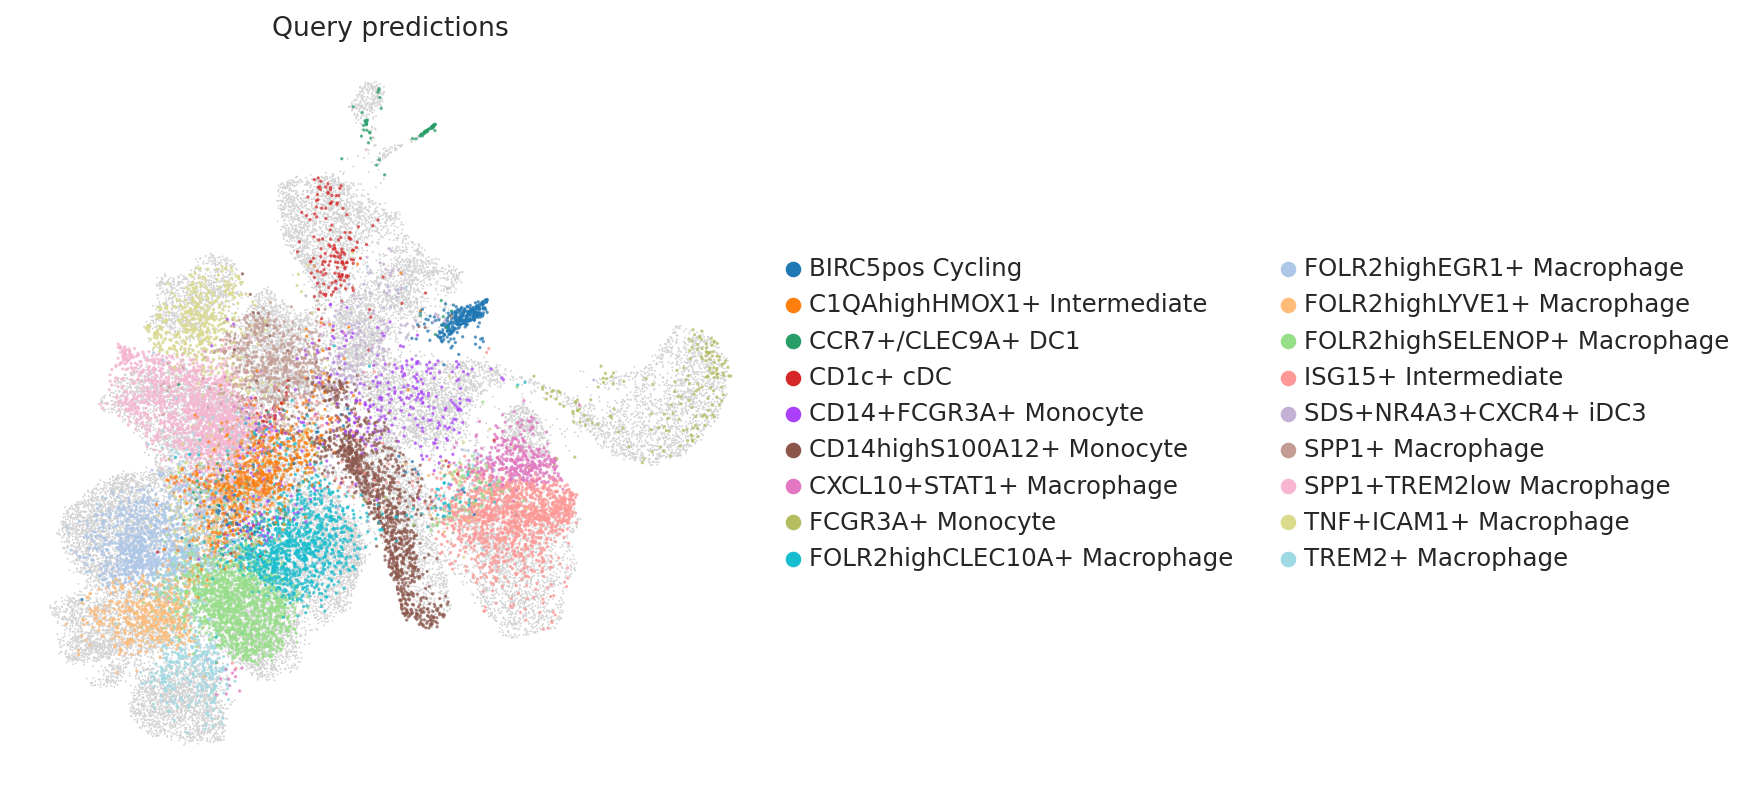

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


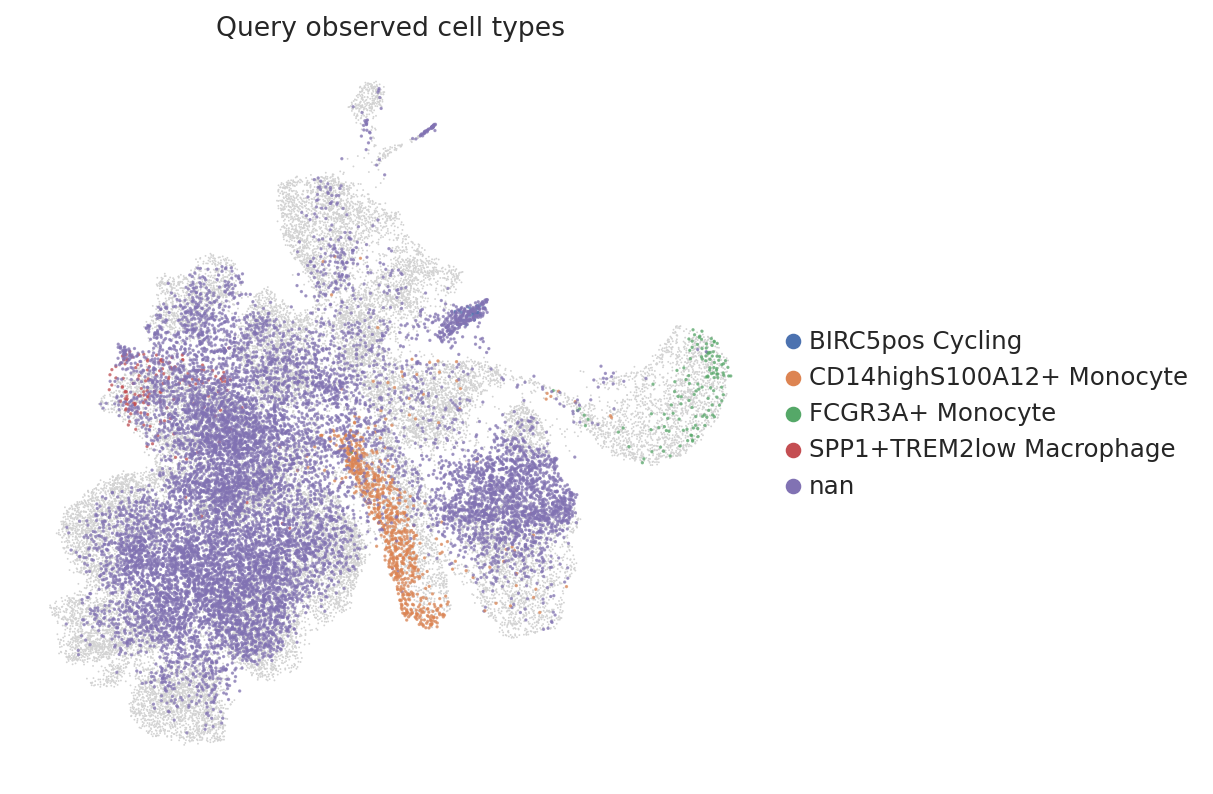

In [141]:
# Subset to only organoid cells for focused analysis
organoid_subset = merged_adata[merged_adata.obs["source"] == "Organoid"]

ax = sc.pl.umap(
    merged_adata,
    frameon=False,
    show=False,
)

sc.pl.umap(
    organoid_subset,
    color=[SCANVI_PREDICTIONS_KEY],
    frameon=False,
    title="Query predictions",
    ax=ax,
    alpha=0.7,
)

ax = sc.pl.umap(
    merged_adata,
    frameon=False,
    show=False,
)

sc.pl.umap(
    organoid_subset,
    color=["STACASclusters"],
    frameon=False,
    title="Query observed cell types",
    ax=ax,
    alpha=0.7,
)

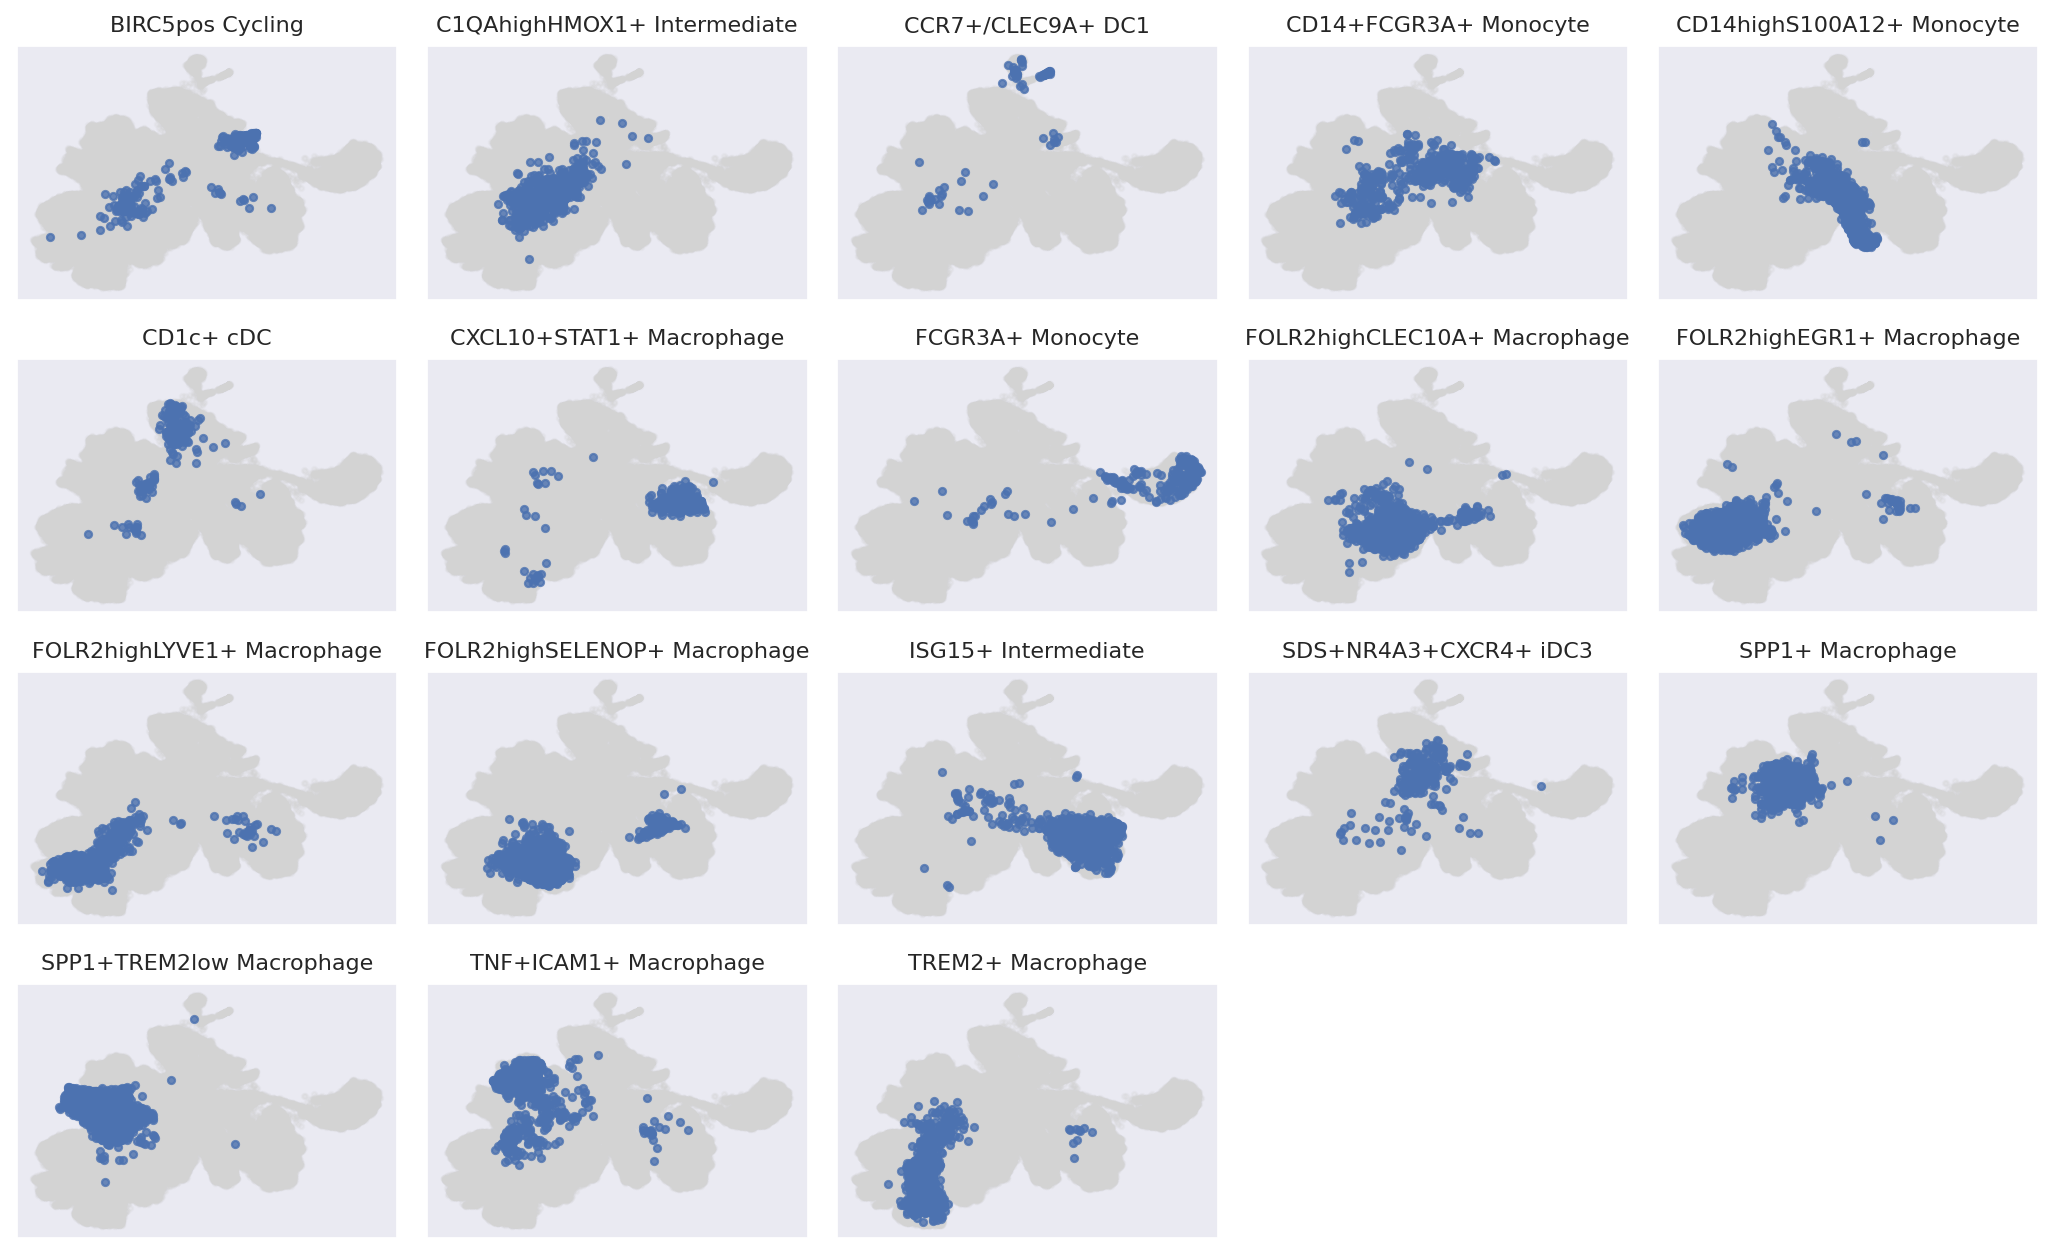

In [142]:
# Visualize SCANVI predictions for organoid cells in detail
umap_coords = merged_adata.obsm["X_umap"]
organoid_subset = merged_adata[merged_adata.obs["source"] == "Organoid"]
predictions = organoid_subset.obs[SCANVI_PREDICTIONS_KEY].astype(str) 
unique_predictions = np.sort(predictions.unique())
n_predictions = len(unique_predictions)
n_cols = 5
n_rows = int(np.ceil(n_predictions / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 2 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()
for i, prediction in enumerate(unique_predictions):
    ax = axes[i]
    mask = organoid_subset.obs[SCANVI_PREDICTIONS_KEY] == prediction
    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], color="lightgray", alpha=0.2, s=5)
    ax.scatter(
        organoid_subset.obsm["X_umap"][mask, 0], 
        organoid_subset.obsm["X_umap"][mask, 1], 
        s=10, alpha=0.8, label=f"{prediction}"
    )
    ax.set_title(f"{prediction}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

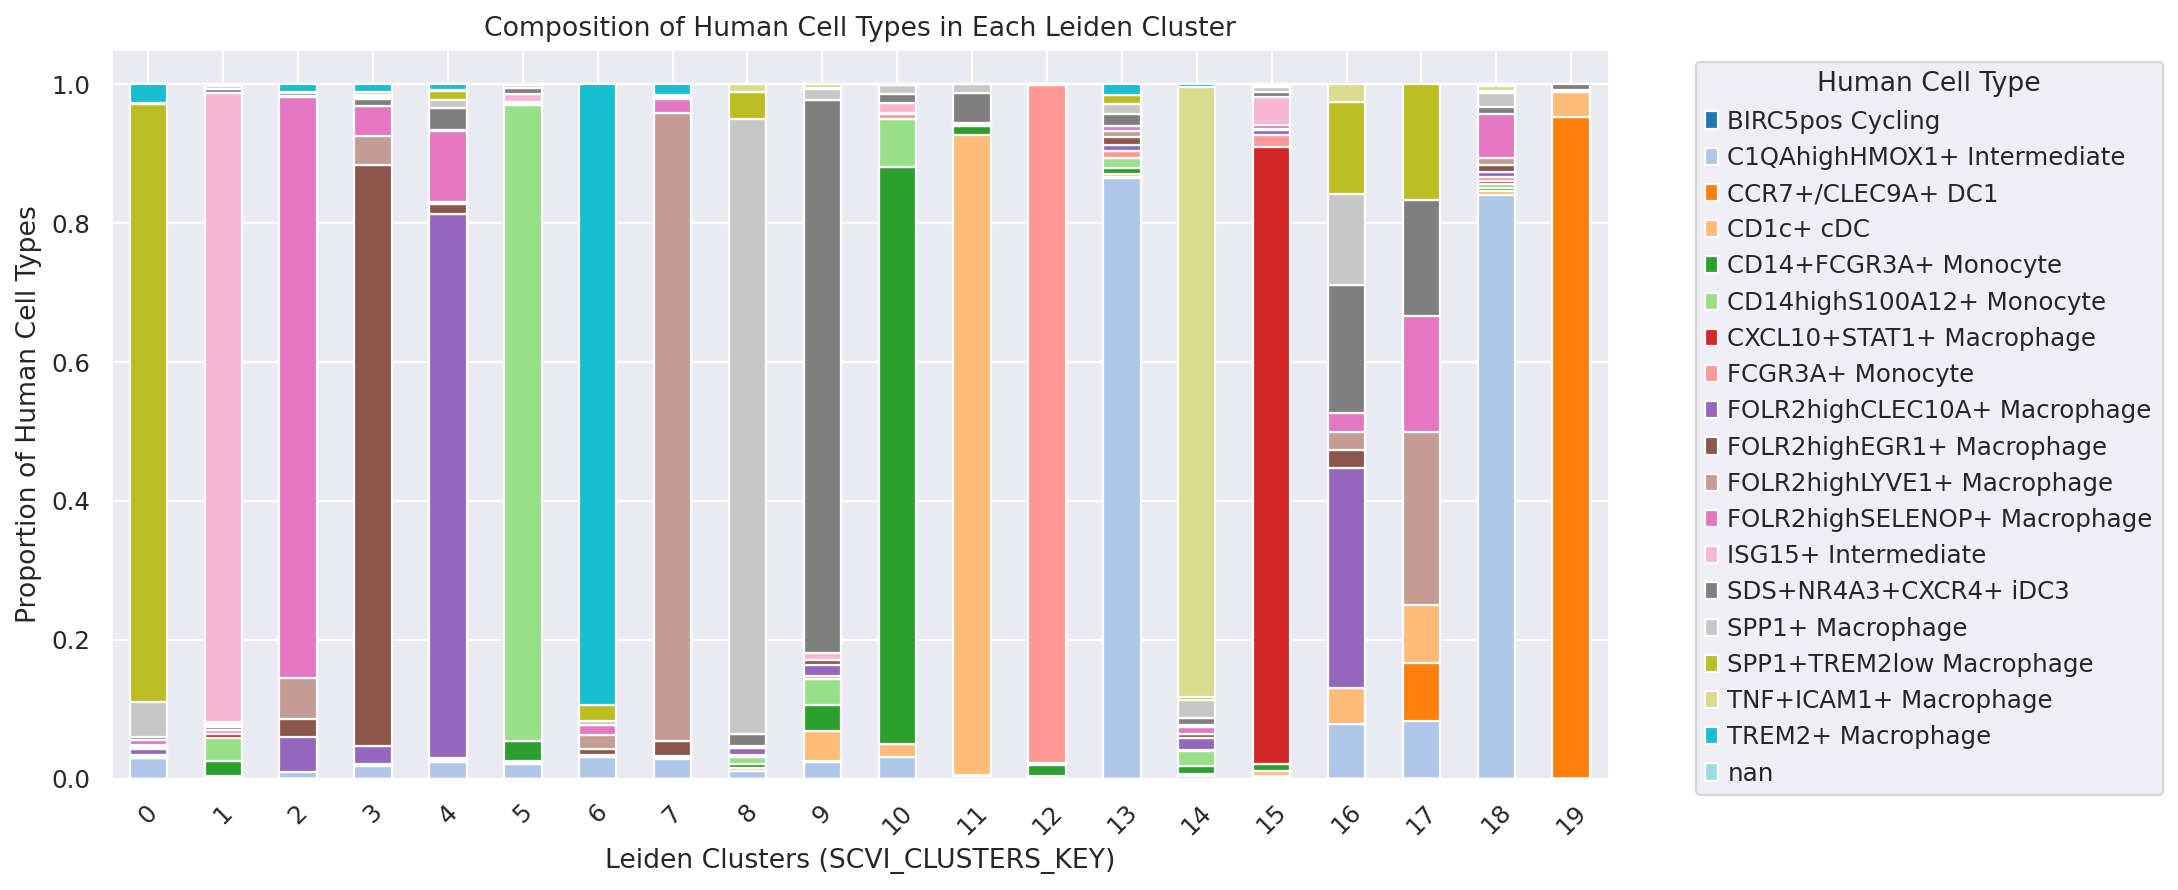

In [144]:
# Analyze composition of human cell types within each cluster
cluster_key = SCVI_CLUSTERS_KEY 
human_df = merged_adata.obs[merged_adata.obs["source"] == "Human"][[cluster_key, "STACASclusters"]]
cluster_counts = human_df.groupby([cluster_key, "STACASclusters"]).size().reset_index(name="count")
cluster_sums = cluster_counts.groupby(cluster_key)["count"].transform("sum")
cluster_counts["proportion"] = cluster_counts["count"] / cluster_sums
stacked_data = cluster_counts.pivot(index=cluster_key, columns="STACASclusters", values="proportion").fillna(0)
stacked_data.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")

plt.xlabel("Leiden Clusters (SCVI_CLUSTERS_KEY)")
plt.ylabel("Proportion of Human Cell Types")
plt.title("Composition of Human Cell Types in Each Leiden Cluster")
plt.legend(title="Human Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.show()

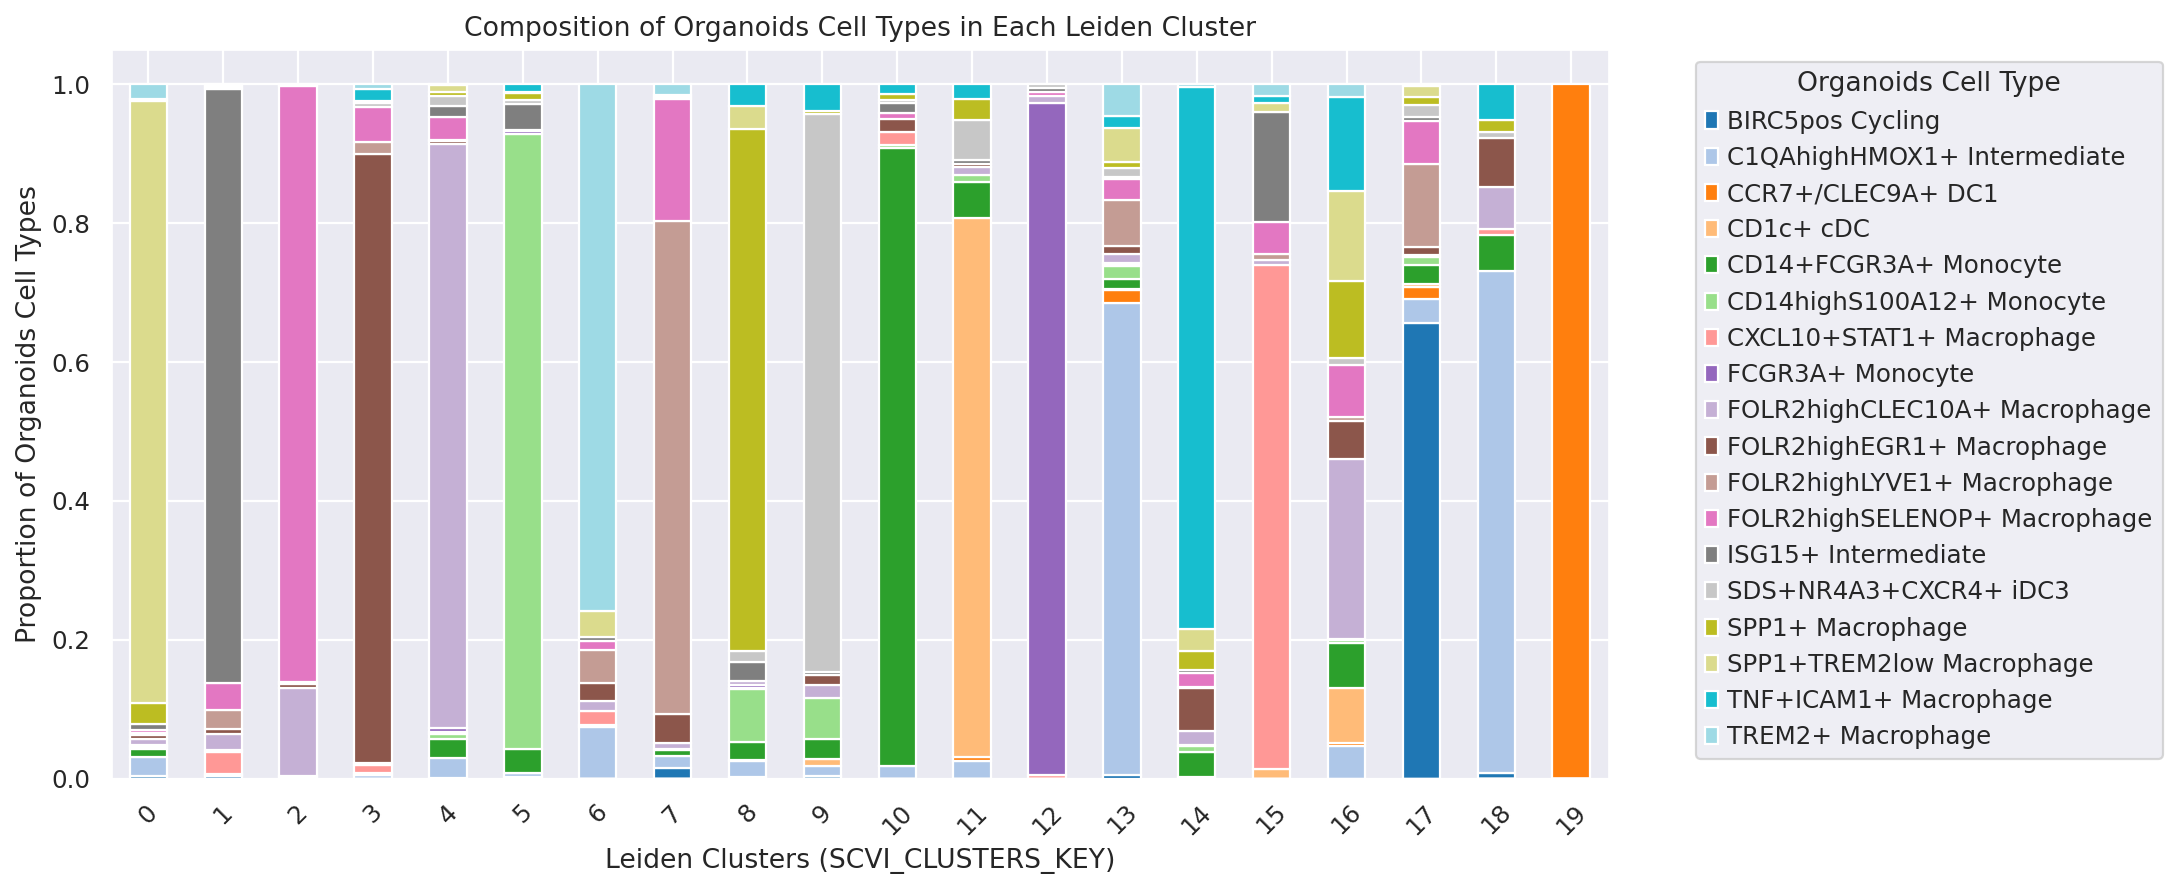

In [145]:
# Analyze composition of organoid predicted cell types within each cluster
cluster_key = SCVI_CLUSTERS_KEY 
human_df = merged_adata.obs[merged_adata.obs["source"] == "Organoid"][[cluster_key, SCANVI_PREDICTIONS_KEY]]
cluster_counts = human_df.groupby([cluster_key, SCANVI_PREDICTIONS_KEY]).size().reset_index(name="count")
cluster_sums = cluster_counts.groupby(cluster_key)["count"].transform("sum")
cluster_counts["proportion"] = cluster_counts["count"] / cluster_sums
stacked_data = cluster_counts.pivot(index=cluster_key, columns=SCANVI_PREDICTIONS_KEY, values="proportion").fillna(0)
stacked_data.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")

plt.xlabel("Leiden Clusters (SCVI_CLUSTERS_KEY)")
plt.ylabel("Proportion of Organoids Cell Types")
plt.title("Composition of Organoids Cell Types in Each Leiden Cluster")
plt.legend(title="Organoids Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.show()

<Figure size 960x480 with 0 Axes>

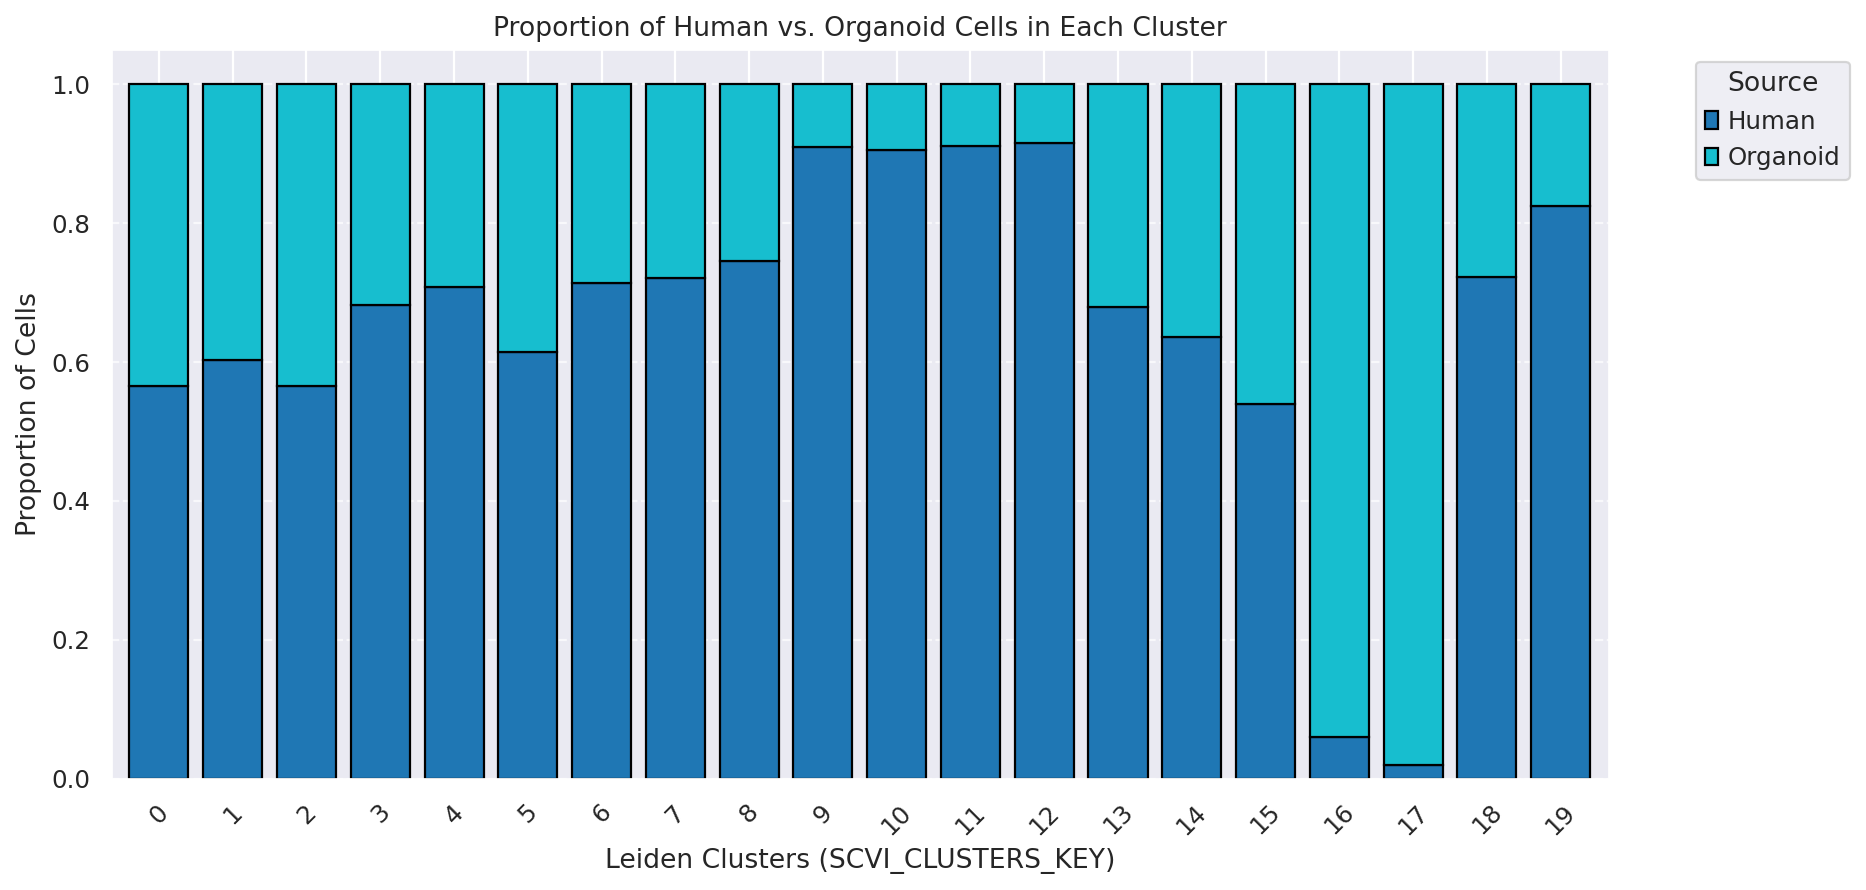

In [146]:
# Analyze source (Human vs Organoid) composition within each cluster
source_df = merged_adata.obs[[cluster_key, "source"]]

cluster_source_counts = source_df.groupby([cluster_key, "source"]).size().reset_index(name="count")

cluster_sums = cluster_source_counts.groupby(cluster_key)["count"].transform("sum")
cluster_source_counts["proportion"] = cluster_source_counts["count"] / cluster_sums
stacked_data = cluster_source_counts.pivot(index=cluster_key, columns="source", values="proportion").fillna(0)

plt.figure(figsize=(12, 6))
stacked_data.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10", edgecolor="black", width=0.8)

plt.xlabel("Leiden Clusters (SCVI_CLUSTERS_KEY)")
plt.ylabel("Proportion of Cells")
plt.title("Proportion of Human vs. Organoid Cells in Each Cluster")
plt.legend(title="Source", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [147]:
SCANVI_PREDICTIONS_KEY

'predictions_scanvi'

In [148]:
# Create subsets for organoid and human cells
organoids_subset = merged_adata[merged_adata.obs["source"] == "Organoid"]
organoids_subset

View of AnnData object with n_obs × n_vars = 13558 × 2500
    obs: 'orig.ident', 'STACASclusters', 'STACASExperiment', 'STACASsample', 'source', '_scvi_batch', '_scvi_labels', 'predictions_scanvi', 'score_scanvi', 'leiden_scVI'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden', 'umap', 'source_colors', 'leiden_scVI_colors'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI', 'X_scANVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [149]:
human_subset = merged_adata[merged_adata.obs["source"] == "Human"]
human_subset

View of AnnData object with n_obs × n_vars = 29852 × 2500
    obs: 'orig.ident', 'STACASclusters', 'STACASExperiment', 'STACASsample', 'source', '_scvi_batch', '_scvi_labels', 'predictions_scanvi', 'score_scanvi', 'leiden_scVI'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden', 'umap', 'source_colors', 'leiden_scVI_colors'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI', 'X_scANVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [150]:
merged_adata.obs["STACASclusters"].value_counts()

nan                             12413
CD14highS100A12+ Monocyte        2830
SPP1+TREM2low Macrophage         2152
FCGR3A+ Monocyte                 2131
FOLR2highLYVE1+ Macrophage       2000
TREM2+ Macrophage                2000
SPP1+ Macrophage                 2000
SDS+NR4A3+CXCR4+ iDC3            2000
ISG15+ Intermediate              2000
FOLR2highSELENOP+ Macrophage     2000
FOLR2highEGR1+ Macrophage        2000
C1QAhighHMOX1+ Intermediate      2000
FOLR2highCLEC10A+ Macrophage     2000
CD14+FCGR3A+ Monocyte            2000
CD1c+ cDC                        2000
TNF+ICAM1+ Macrophage            1003
CXCL10+STAT1+ Macrophage          514
CCR7+/CLEC9A+ DC1                 335
BIRC5pos Cycling                   32
Name: STACASclusters, dtype: int64

In [151]:
celltype_colors = {
    "CD14highS100A12+ Monocyte": "#FFC2CB",  
    "SPP1+TREM2low Macrophage": "#FF7FD1",  
    "FCGR3A+ Monocyte": "#9583F0",  
    "FOLR2highLYVE1+ Macrophage": "#DC143C",  
    "TREM2+ Macrophage": "#FF1493",  
    "SPP1+ Macrophage": "#8B008B",  
    "SDS+NR4A3+CXCR4+ iDC3": "#0CC6F0",  
    "ISG15+ Intermediate": "#52ECF7",  
    "FOLR2highSELENOP+ Macrophage": "#96FFEC",  
    "C1QAhighHMOX1+ Intermediate": "#32FAC5",  
    "FOLR2highEGR1+ Macrophage": "#FFA500",  
    "FOLR2highCLEC10A+ Macrophage": "#1E90FF",  
    "CD14+FCGR3A+ Monocyte": "#FFFF00",  
    "CD1c+ cDC": "#DFFF00",  
    "TNF+ICAM1+ Macrophage": "#0CED22",  
    "CXCL10+STAT1+ Macrophage": "#FF00FF",  
    "CCR7+/CLEC9A+ DC1": "#710AF7",  
    "BIRC5pos Cycling": "#104E8B",  
}

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[

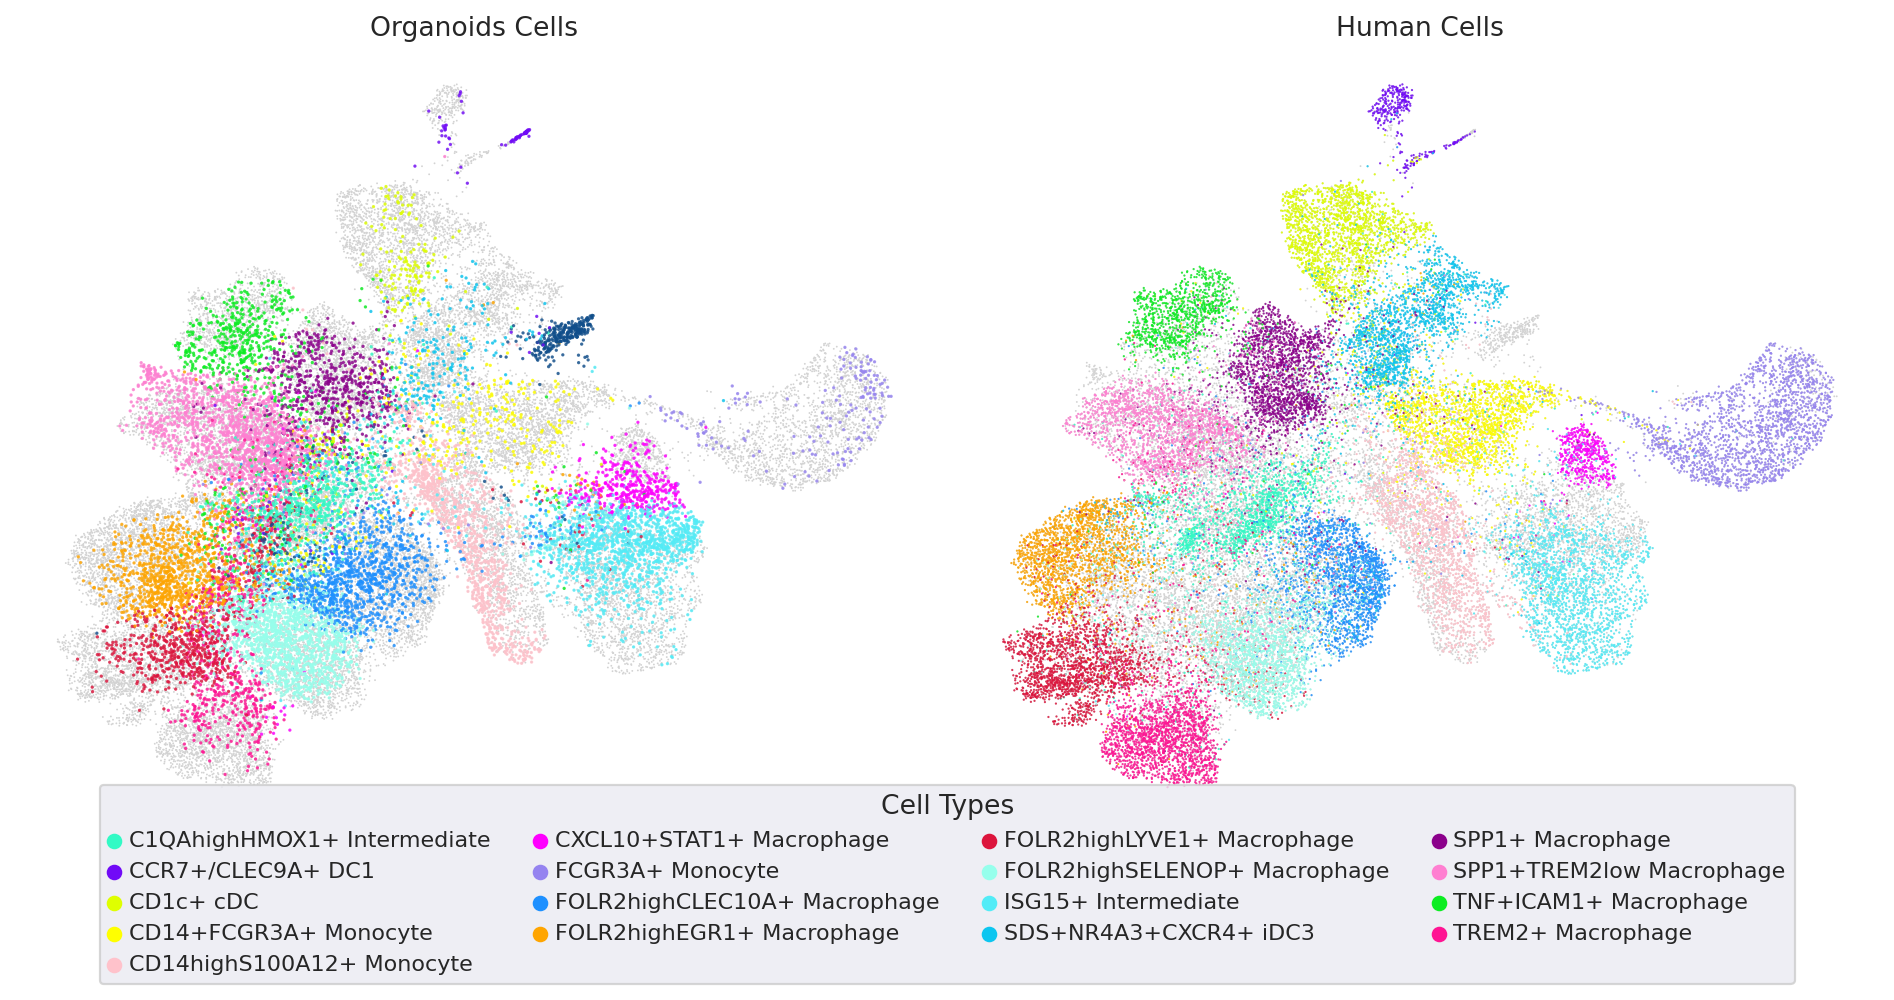

In [152]:
# Create side-by-side comparison of organoid predictions vs human annotations
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

sc.pl.umap(
    merged_adata,
    frameon=False,
    show=False,
    ax=axes[0], 
)

sc.pl.umap(
    organoids_subset,
    color=[SCANVI_PREDICTIONS_KEY],
    frameon=False,
    title="Organoids Cells",
    alpha=0.8,
    palette=celltype_colors,
    show=False,
    ax=axes[0], 
)

sc.pl.umap(
    merged_adata,
    frameon=False,
    show=False,
    ax=axes[1],  
)

sc.pl.umap(
    human_subset,
    color=["STACASclusters"],
    frameon=False,
    title="Human Cells",
    alpha=0.8,
    palette=celltype_colors,
    show=False,
    ax=axes[1], 
)

handles, labels = axes[1].get_legend_handles_labels()  

axes[0].legend_.remove()
axes[1].legend_.remove()

fig.legend(
    handles,
    labels,
    loc="lower center",  
    title="Cell Types",
    bbox_to_anchor=(0.5, -0.05),  
    ncol=4,  
    fontsize=10, 
)

plt.tight_layout(rect=[0, 0.1, 1, 1])  
plt.show()

In [153]:
# Function to create split UMAP plots by category
def split_umap(adata, split_by, ncol=2, nrow=None, **kwargs):
    ax = sc.pl.umap(adata, color=split_by, show=False)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    categories = adata.obs[split_by].cat.categories
    if nrow is None:
        nrow = int(np.ceil(len(categories) / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    axs = axs.flatten()
    for i, cat in enumerate(categories):
        ax = axs[i]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        sc.pl.umap(adata[adata.obs[split_by] == cat], ax=ax, show=False, title=cat, **kwargs)
    plt.tight_layout()

In [154]:
merged_adata.obs

orig.ident               STACASclusters  \
TACGCTCTCTTAAGGC-1_1_24M0        SA272_SYN  C1QAhighHMOX1+ Intermediate   
TTGCTGCCAATCGAAA-1_5_35M0               A5  C1QAhighHMOX1+ Intermediate   
TGTTACTCATTCAGCA-1_3_26M0        SA276_SYN  C1QAhighHMOX1+ Intermediate   
CGGACGTGTACAGTGG-1_12_12M0  ResistantSA151  C1QAhighHMOX1+ Intermediate   
GTCCACTGTCTCGGAC-1_2_25M0        SA271_SYN  C1QAhighHMOX1+ Intermediate   
...                                    ...                          ...   
56570281M4                           M_SMK                          nan   
56575791M4                           M_SMK                          nan   
56581519M4                           M_SMK                          nan   
56596774M4                           M_SMK                          nan   
56597423M4                           M_SMK                          nan   

                           STACASExperiment    STACASsample    source  \
TACGCTCTCTTAAGGC-1_1_24M0          Immunity       SA272_SYN     Human   
TTGCTGCCAATCGAAA-1_5_35M0          Immunity              A5     Human   
TGTTACTCATTCAGCA-1_3_26M0          Immunity       SA276_SYN     Human   
CGGACGTGTACAGTGG-1_12_12M0         Immunity  ResistantSA151     Human   
GTCCACTGTCTCGGAC-1_2_25M0          Immunity       SA271_SYN     Human   
...                                     ...             ...       ...   
56570281M4                      Organoid_SF              SF  Organoid   
56575791M4                    Organoid_Unst            Unst  Organoid   
56581519M4                    Organoid_Unst            Unst  Organoid   
56596774M4                    Organoid_Unst            Unst  Organoid   
56597423M4                    Organoid_Unst            Unst  Organoid   

                            _scvi_batch  _scvi_labels  \
TACGCTCTCTTAAGGC-1_1_24M0            57             1   
TTGCTGCCAATCGAAA-1_5_35M0             3             1   
TGTTACTCATTCAGCA-1_3_26M0            59             1   
CGGACGTGTACAGTGG-1_12_12M0           41             1   
GTCCACTGTCTCGGAC-1_2_25M0            55             1   
...                                 ...           ...   
56570281M4                           65            18   
56575791M4                           66            18   
56581519M4                           66            18   
56596774M4                           66            18   
56597423M4                           66            18   

                                      predictions_scanvi  score_scanvi  \
TACGCTCTCTTAAGGC-1_1_24M0    C1QAhighHMOX1+ Intermediate      1.000000   
TTGCTGCCAATCGAAA-1_5_35M0    C1QAhighHMOX1+ Intermediate      0.999345   
TGTTACTCATTCAGCA-1_3_26M0    C1QAhighHMOX1+ Intermediate      1.000000   
CGGACGTGTACAGTGG-1_12_12M0             TREM2+ Macrophage      0.674136   
GTCCACTGTCTCGGAC-1_2_25M0    C1QAhighHMOX1+ Intermediate      0.959442   
...                                                  ...           ...   
56570281M4                   C1QAhighHMOX1+ Intermediate      0.902352   
56575791M4                           ISG15+ Intermediate      1.000000   
56581519M4                  FOLR2highCLEC10A+ Macrophage      0.724785   
56596774M4                           ISG15+ Intermediate      0.999981   
56597423M4                  FOLR2highCLEC10A+ Macrophage      1.000000   

                           leiden_scVI  
TACGCTCTCTTAAGGC-1_1_24M0           18  
TTGCTGCCAATCGAAA-1_5_35M0           13  
TGTTACTCATTCAGCA-1_3_26M0           18  
CGGACGTGTACAGTGG-1_12_12M0          13  
GTCCACTGTCTCGGAC-1_2_25M0           13  
...                                ...  
56570281M4                           0  
56575791M4                           1  
56581519M4                           4  
56596774M4                          15  
56597423M4                           4  

[43410 rows x 10 columns]

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


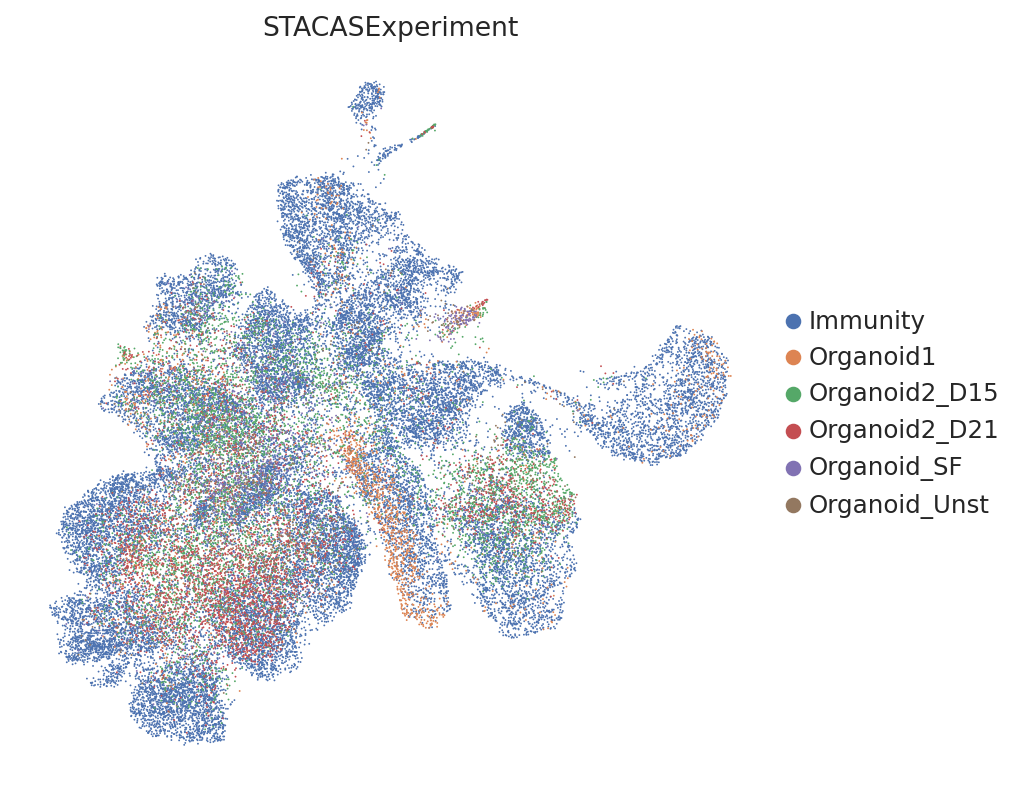

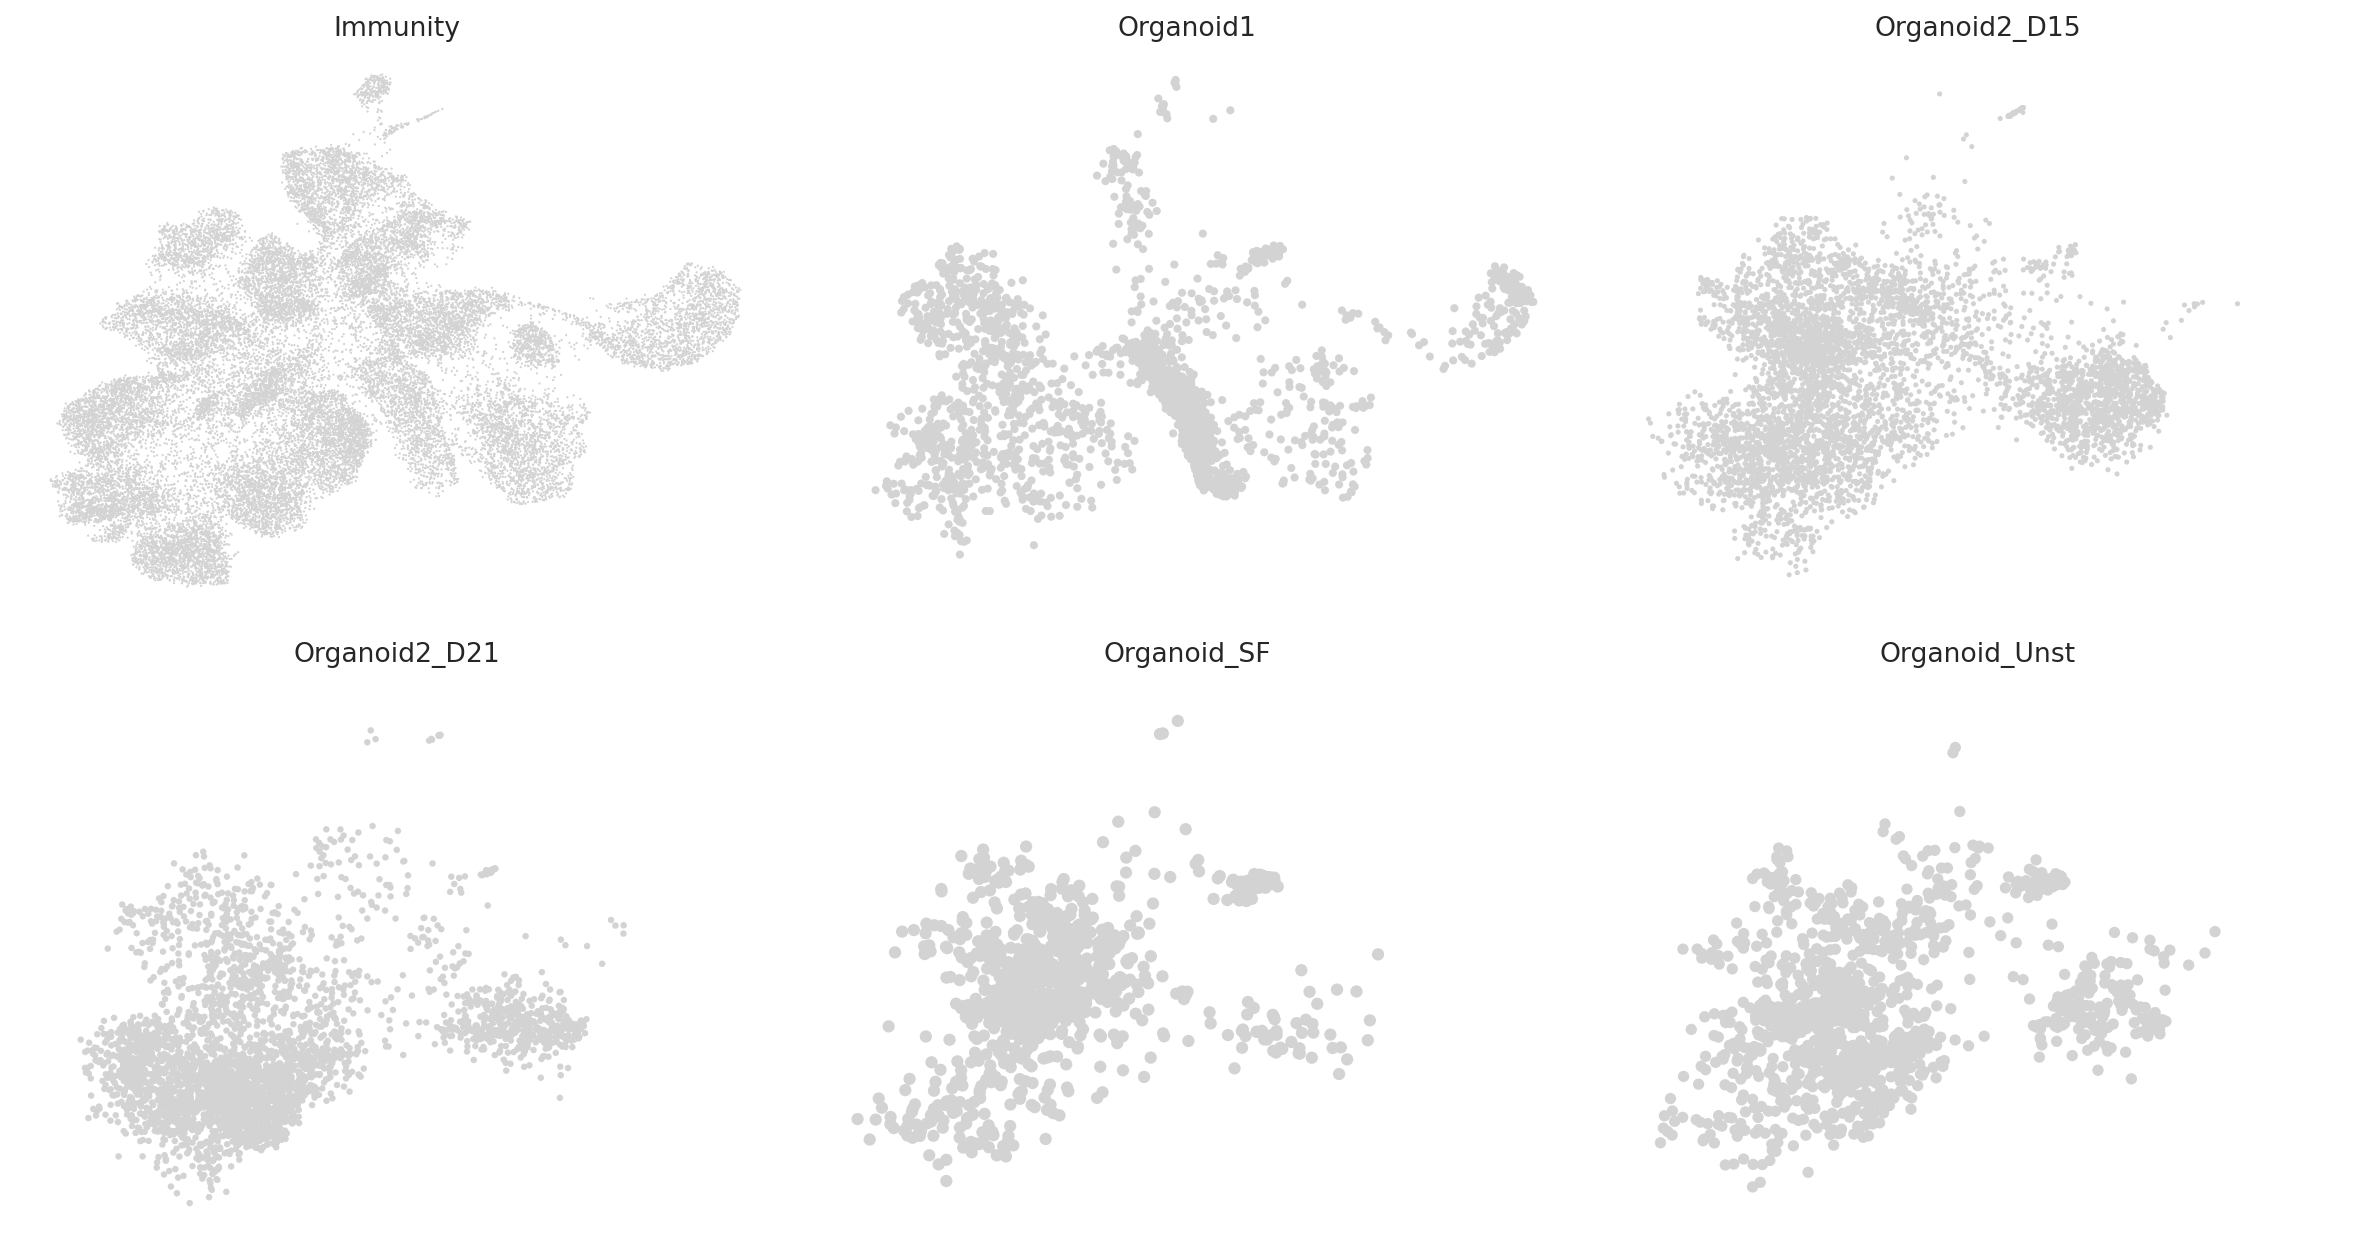

In [155]:
split_umap(merged_adata, split_by="STACASExperiment", ncol=3)

In [156]:
merged_adata

AnnData object with n_obs × n_vars = 43410 × 2500
    obs: 'orig.ident', 'STACASclusters', 'STACASExperiment', 'STACASsample', 'source', '_scvi_batch', '_scvi_labels', 'predictions_scanvi', 'score_scanvi', 'leiden_scVI'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden', 'umap', 'source_colors', 'leiden_scVI_colors', 'STACASExperiment_colors'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI', 'X_scANVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [157]:
merged_adata.write("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Macrophages.Organoid.ST.scanpy_3.h5ad")

In [14]:
merged_adata = sc.read("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Macrophages.Organoid.ST.scanpy_2.h5ad")

Only considering the two last: ['.scanpy_2', '.h5ad'].
Only considering the two last: ['.scanpy_2', '.h5ad'].


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


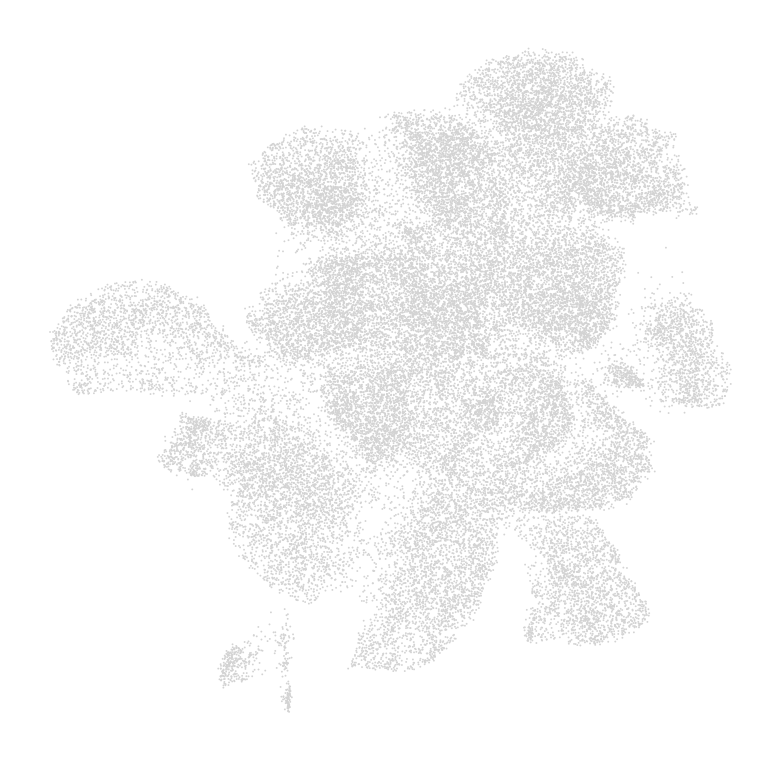

In [11]:
sc.pl.umap(merged_adata)

In [76]:
# Clean up SCVI metadata
del merged_adata.obsm['_scvi_extra_categorical_covs']

In [77]:
# Copy annotations back to original AnnData object
original_adata.obs = merged_adata.obs.copy()
original_adata.obsm = merged_adata.obsm.copy()

In [79]:
# Save integrated data in h5ad format
original_adata.write("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Macrophages.Organoid.ST.scanpy_compatible_3.h5ad")

In [81]:
# Export data in matrix format compatible with other tools (e.g., Seurat)
import scipy.io
import pandas as pd

# Save sparse matrix (adata.X)
scipy.io.mmwrite("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Macrophages.Organoid.ST.scanpy_counts.mtx", original_adata.X.T)  # Transpose to match Seurat's genes x cells format

# Save gene names (features)
pd.DataFrame(original_adata.var_names).to_csv("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Macrophages.Organoid.ST.scanpy_features.tsv", sep="\t", index=False, header=False)

# Save cell barcodes (observations)
pd.DataFrame(original_adata.obs_names).to_csv("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Macrophages.Organoid.ST.scanpy_barcodes.tsv", sep="\t", index=False, header=False)

In [82]:
# Export UMAP coordinates (stored in adata.obsm['X_umap'])
umap_df = pd.DataFrame(original_adata.obsm['X_umap'], columns=['UMAP_1', 'UMAP_2'], index=original_adata.obs_names)
umap_df.to_csv("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Macrophages.Organoid.ST.scanpy_umap_coordinates.csv")

In [83]:
original_adata.obs.to_csv("/datastore/Dom/Saved/Mar25_Organoid/Mar25.Macrophages.Organoid.ST.scanpy_metadata.csv")

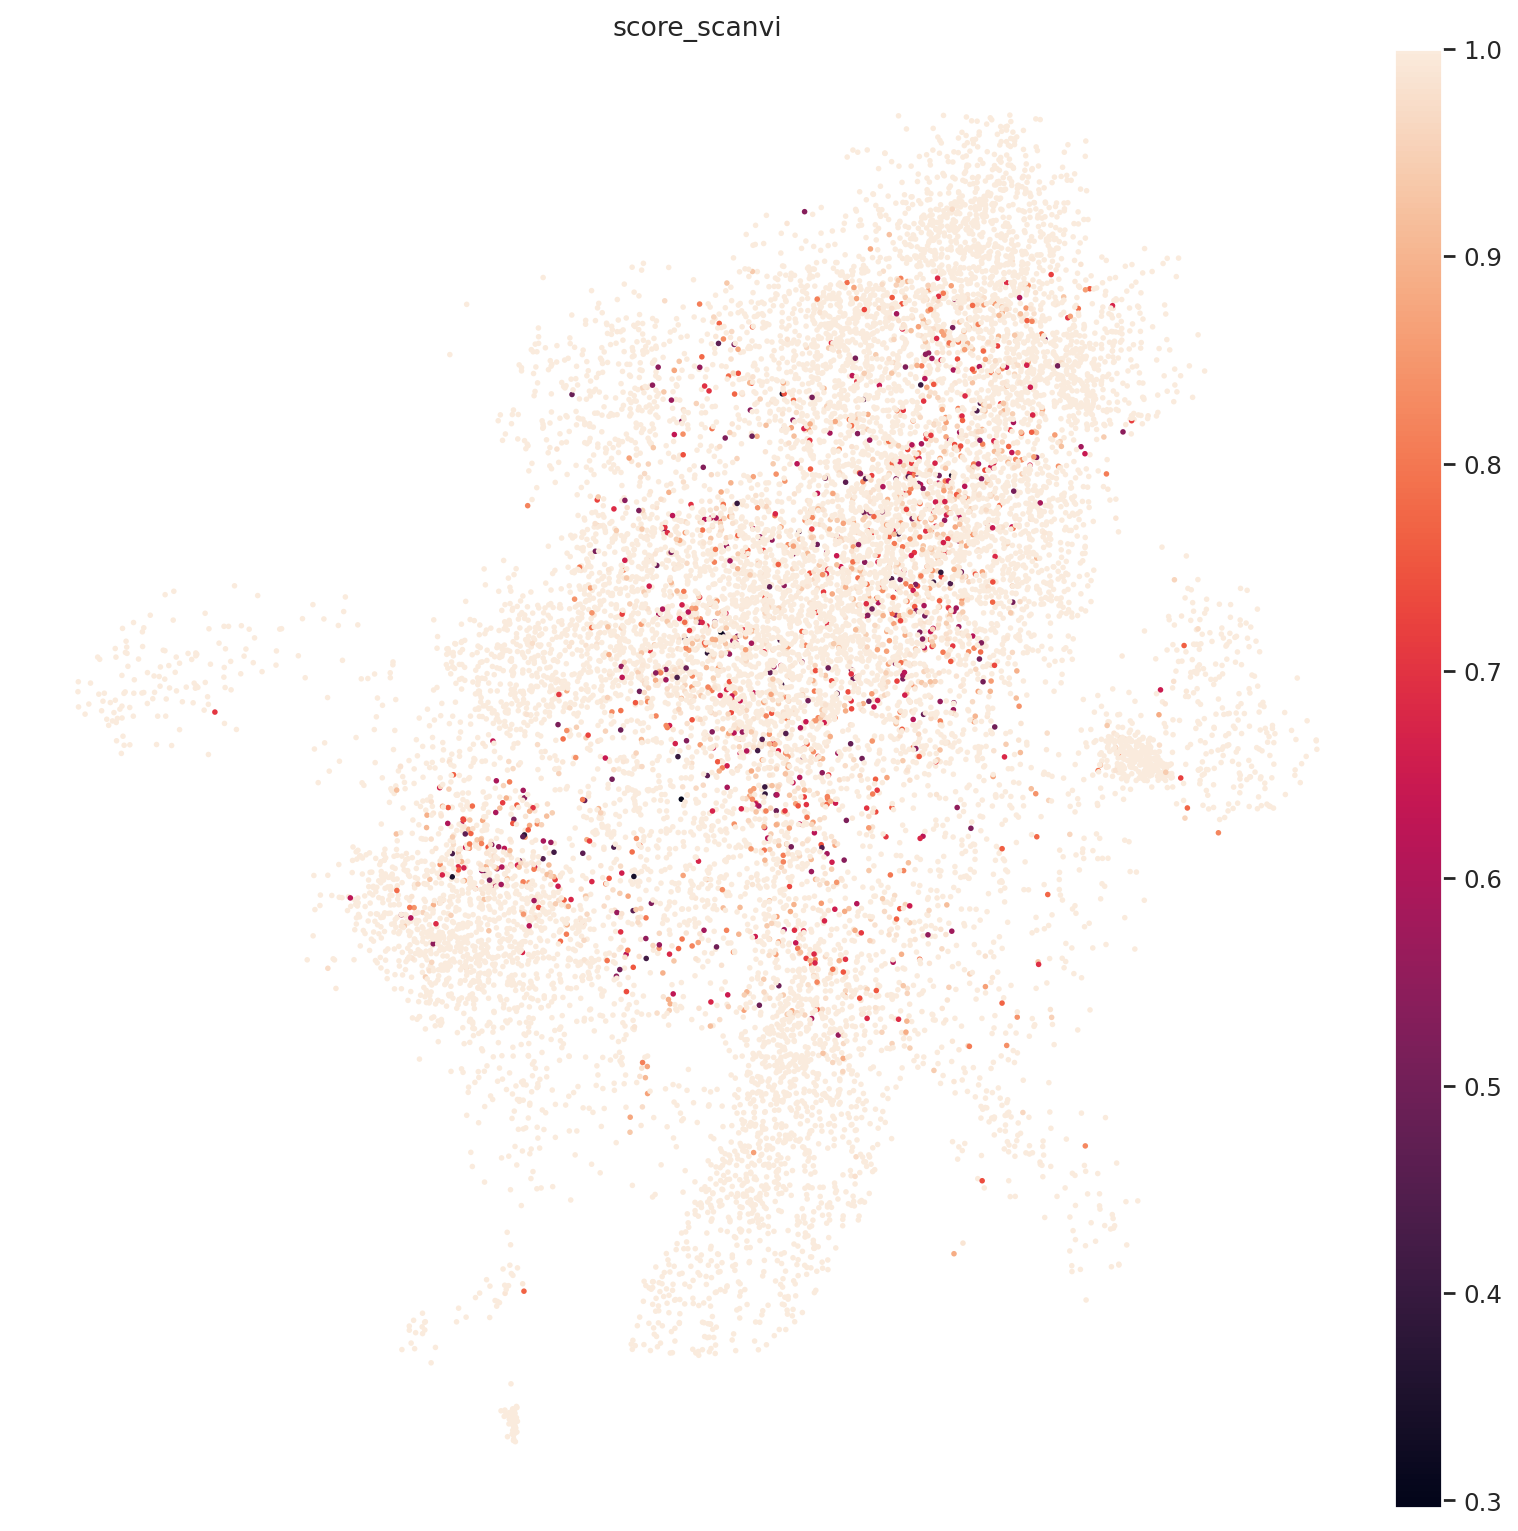

In [ ]:
from matplotlib import rc_context

# Create UMAP plot colored by SCANVI prediction scores
with rc_context({"figure.figsize": (12, 12)}):
    sc.pl.umap(merged_adata_score_plot, size=10, color='score_scanvi', s=25, frameon=False, ncols=1, sort_order=False)

<Axes: ylabel='Frequency'>

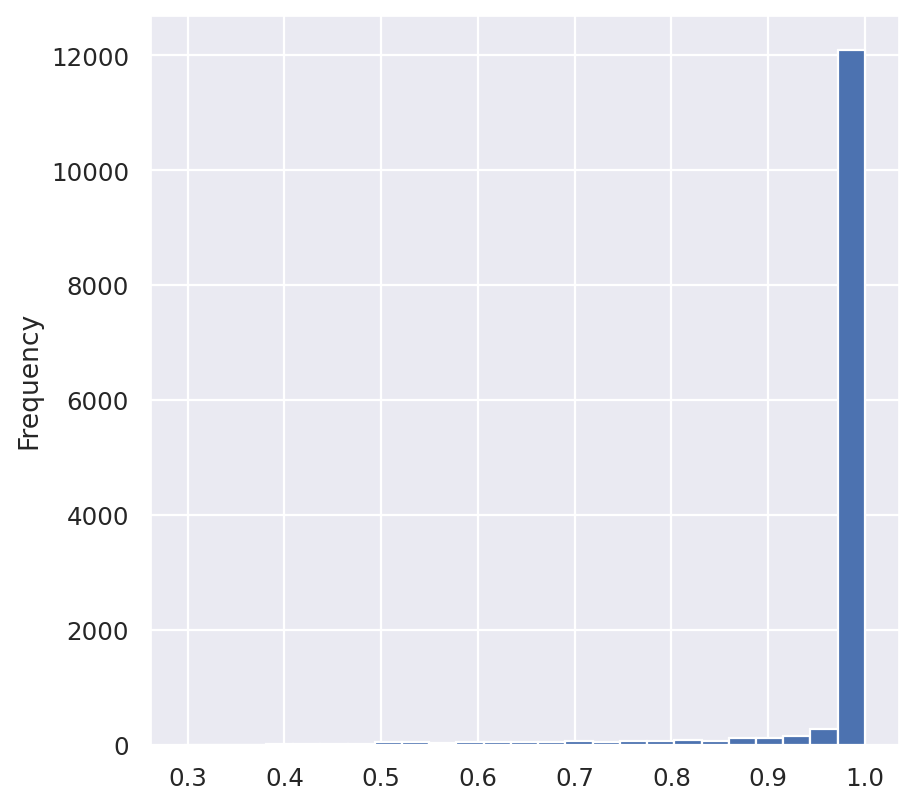

In [40]:
# Plot histogram of SCANVI prediction scores to assess confidence distribution
merged_adata_score_plot.obs.score_scanvi.plot.hist(stacked=True, bins=25)